In [1]:
%matplotlib inline
import os
from collections import OrderedDict
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from data import CodesInDbs, Mappings, Databases
from IPython.display import Latex
import normalize

sns.set_style('whitegrid')
#sns.set_context("poster")
#plt.rcParams['figure.figsize'] = (4, 3)
plt.rc("savefig", dpi=300)

measures_palette = sns.color_palette('Set1', n_colors=2, desat=.5)
measures_palette.reverse()

def graded_recall_palette(n_colors):
    palette = sns.color_palette("Blues", n_colors=n_colors, desat=.6)
    palette.reverse()
    return palette

def graded_precision_palette(n_colors):
    palette = sns.color_palette("Reds", n_colors=n_colors, desat=.6)
    palette.reverse()
    return palette

def mystyle(palette=None, xrot=0, ha='center', ylim=(0,1), ylabel=None, savefig=None):
    class C:
        def __enter__(self):
            if palette is not None:
                palette.__enter__()
        def __exit__(self, exc_type, value, traceback):
            if palette is not None:
                palette.__exit__(exc_type, value, traceback)
            if exc_type is None:
                sns.despine(left=True)
                plt.grid(False, axis='x')
                #if plt.gca().legend_: 
                #    plt.legend(loc=2, bbox_to_anchor=(1, 1))
                plt.gca().get_lines()[0].set_visible(False)
                plt.gca().set_ylim(*ylim)
                plt.xticks(rotation=xrot, ha=ha)
                if ylabel is not None:
                    plt.ylabel(ylabel)
                if savefig:
                    plt.savefig(savefig)
    return C()

#pd.set_option('display.notebook_repr_html', True)
#def _repr_latex_(self):
#    return "\centering{%s}" % self.to_latex()
#pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

PROJECT = os.getenv('COMAP_PROJECT')
print("PROJECT:", PROJECT)

PROJECT: safeguard


In [2]:
with open('../projects/{}/variations.yaml'.format(PROJECT)) as f:
    variations = yaml.load(f)

with open('../projects/{}/config.yaml'.format(PROJECT)) as f:
    config = yaml.load(f)
    databases = Databases.of_config(config)
    coding_systems = config['coding-systems']

with open('../projects/{}/events.yaml'.format(PROJECT)) as f:
    events = yaml.load(f)
    event_names = {}
    for event in events:
        casedef = yaml.load(open('../projects/{}/case-definitions/{}.yaml'.format(PROJECT, event)))
        event_names[event] = casedef['name']

with open('../projects/{}/mappings.yaml'.format(PROJECT)) as f:
    mappings = Mappings.of_raw_data(yaml.load(f), events, databases)
    mappings = normalize.mappings(mappings, databases)

with open('../codes-in-dbs.json') as f:
    codes_in_dbs = CodesInDbs.of_data(json.load(f))
    
with open('../{}.code-stats.csv'.format(PROJECT)) as f:
    code_stats = pd.read_csv(f)
    
def database_label(database):
    return database
    #return "{} ({})".format(database, databases.coding_system(database))

def measure_label(measure):
    return {
        "recall": "Sensitivity",
        "precision": "PPV", # "Positive predictive value",
    }[measure]

def event_label(event):
    return event_names[event]

# Coding systems

In [3]:
pd.DataFrame([
    (database, databases.coding_system(database))
    for database in databases.databases()
], columns=("Database", "Coding system")).set_index("Database")

,Coding system
Database,
Medicare,ICD9CM
IPCI,ICPC2EENG
CPRD,RCD2
GePaRD,ICD10CM


In [4]:
df0 = pd.read_csv('../{}.evaluations.csv'.format(PROJECT))
df = df0['variation event database recall precision'.split()]
df.head()

,variation,event,database,recall,precision
0,2-RN-CHD-RB-PAR.expand,is,IPCI,1.000000,1.000000
1,2-RN-CHD-RB-PAR.expand,is,GePaRD,0.909091,0.588235
2,2-RN-CHD-RB-PAR.expand,is,Medicare,0.300000,0.333333
3,2-RN-CHD-RB-PAR.expand,is,CPRD,0.850000,0.708333
4,2-RN-CHD-RB-PAR.expand,bc,IPCI,0.250000,0.200000


# Baseline

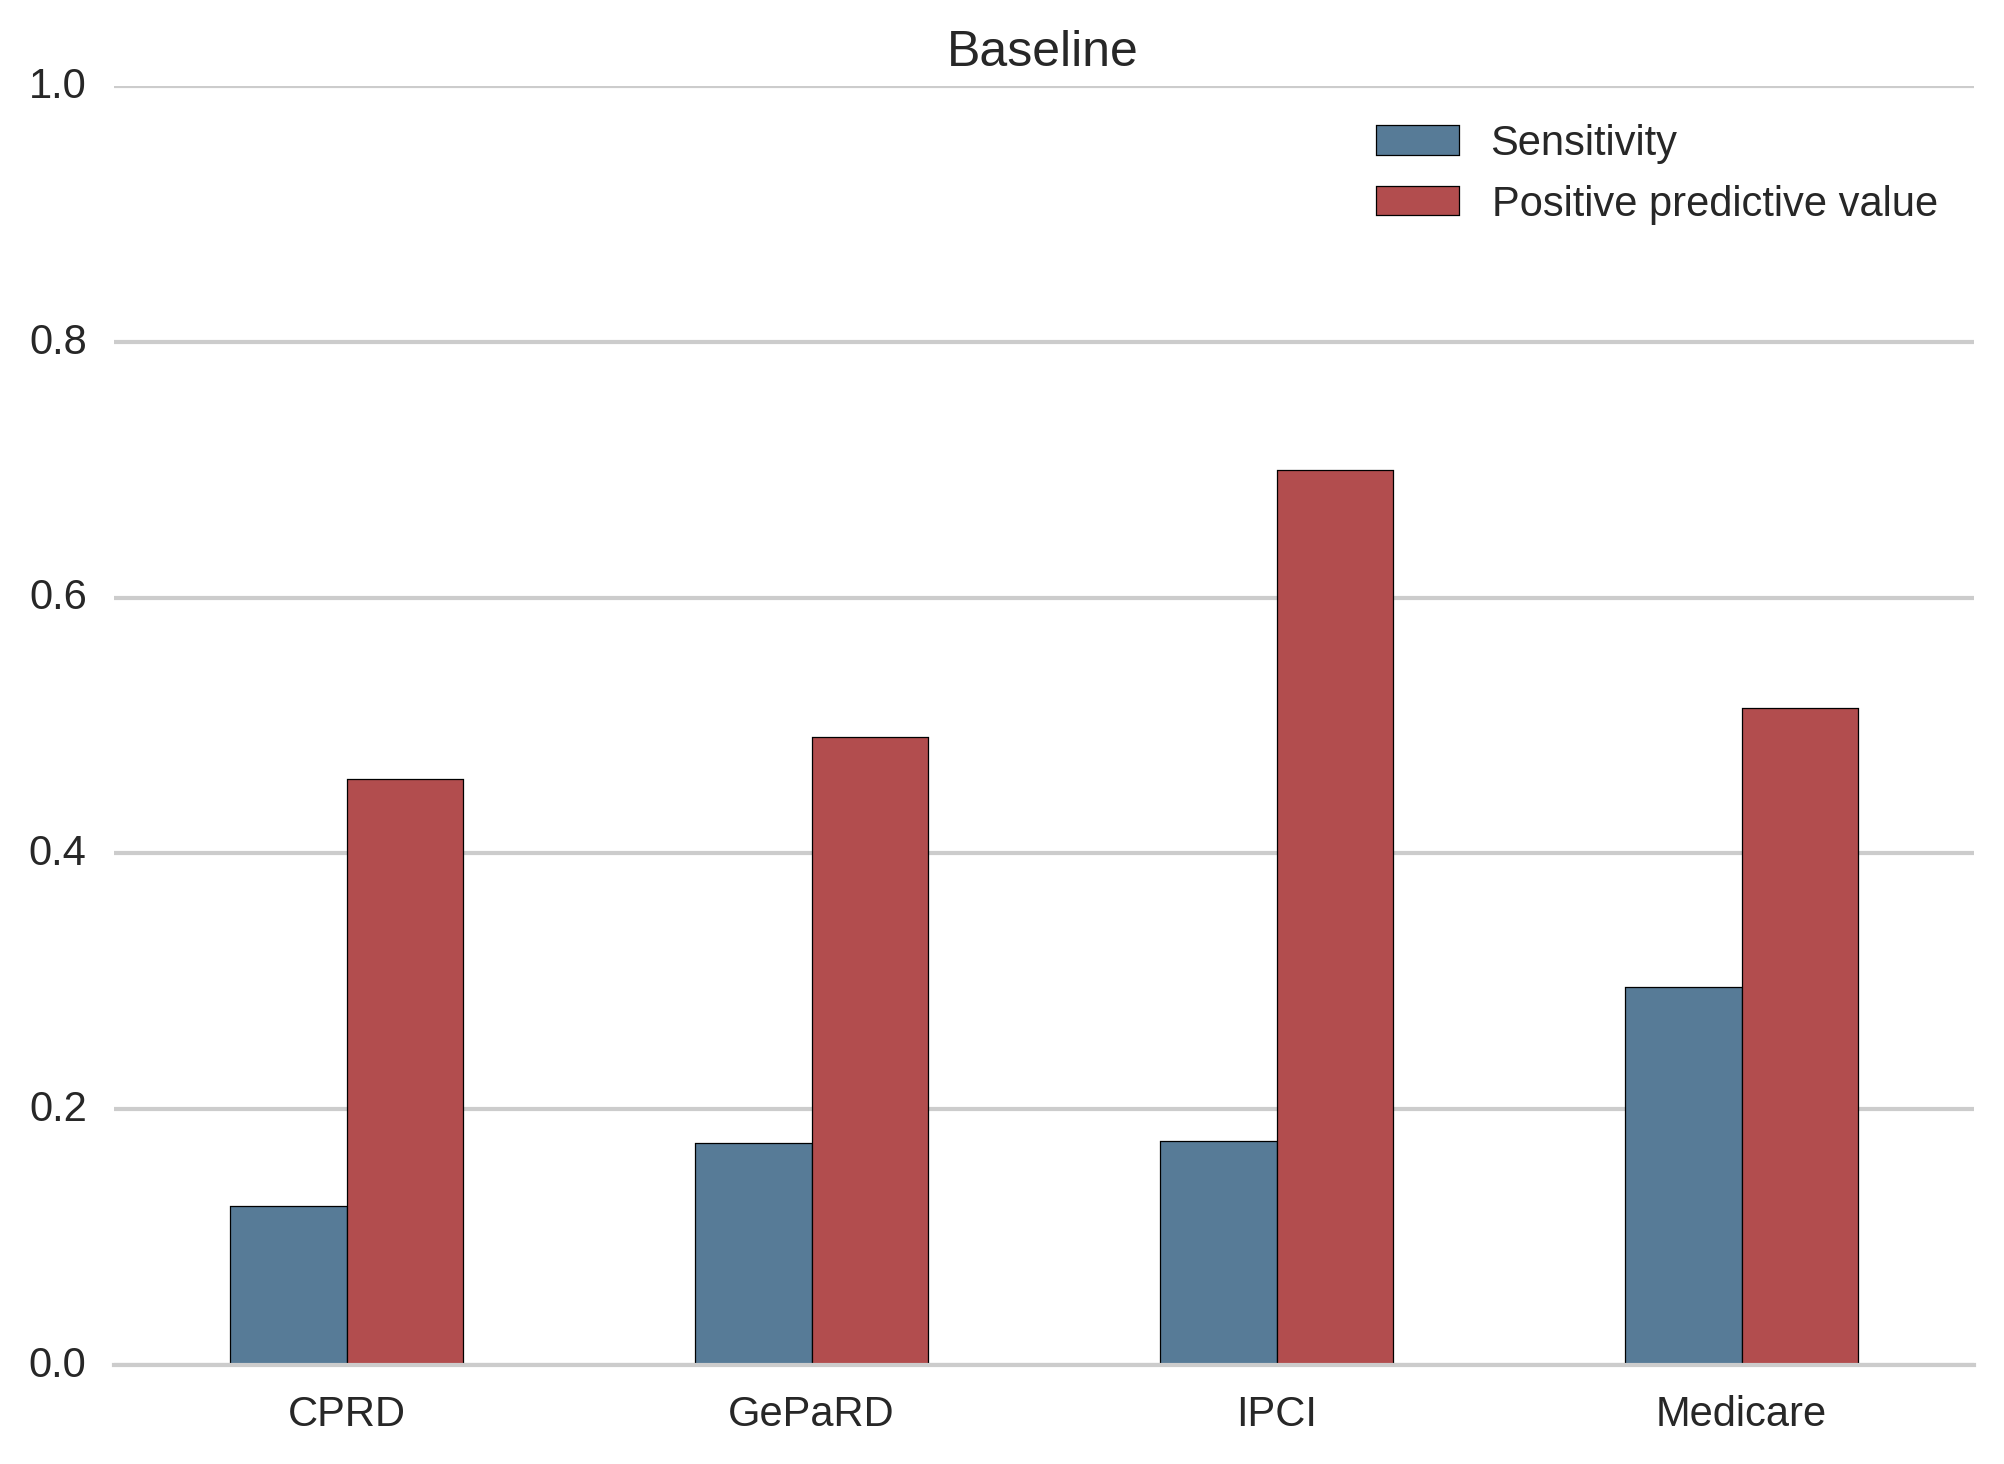

In [5]:
averages_compare = pd.DataFrame([
    df[df.variation == 'baseline'].groupby('database').recall.mean(),
    df[df.variation == 'baseline'].groupby('database').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(database_label)
with mystyle(measures_palette, savefig='baseline.pdf'):
    averages_compare.T.plot(kind='bar', title='Baseline')

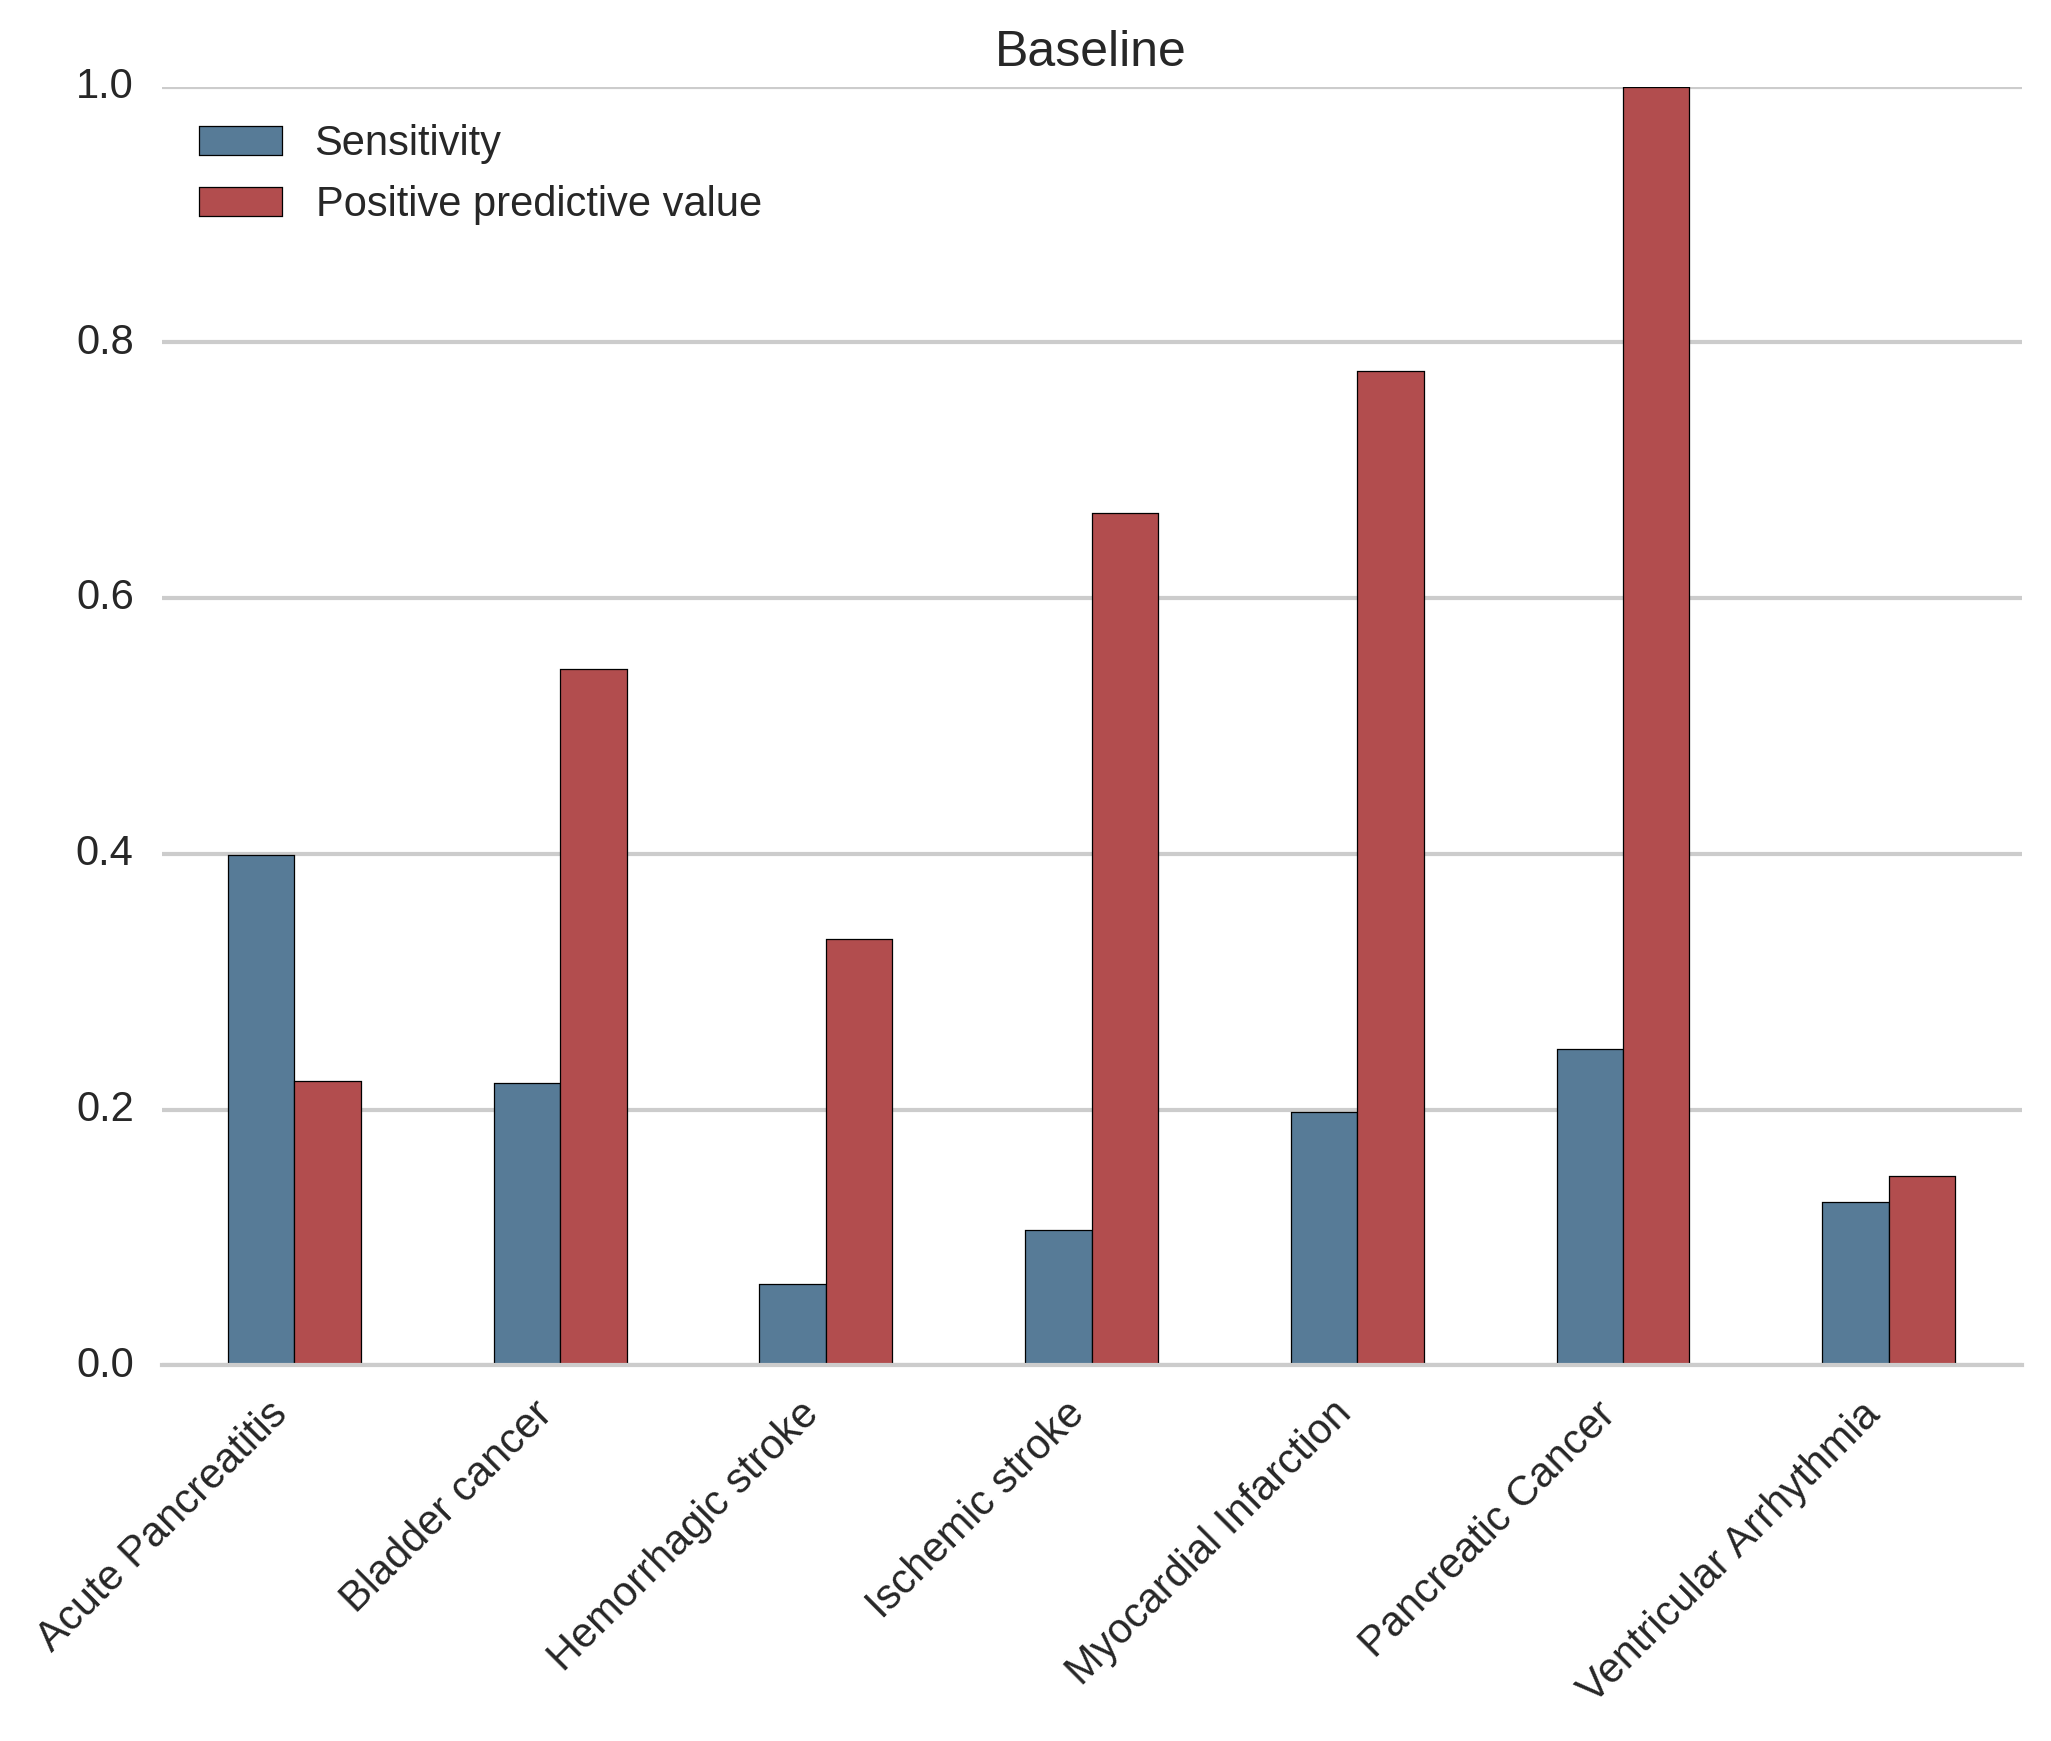

In [6]:
averages_compare = pd.DataFrame([
    df[df.variation == 'baseline'].groupby('event').recall.mean(),
    df[df.variation == 'baseline'].groupby('event').precision.mean(),
])
averages_compare.index = averages_compare.index.map(measure_label)
averages_compare.columns = averages_compare.columns.map(event_label)
with mystyle(measures_palette, xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title='Baseline')

# Max-recall

,CPRD,GePaRD,IPCI,Medicare
Sensitivity,0.929871,0.938033,1,0.988095


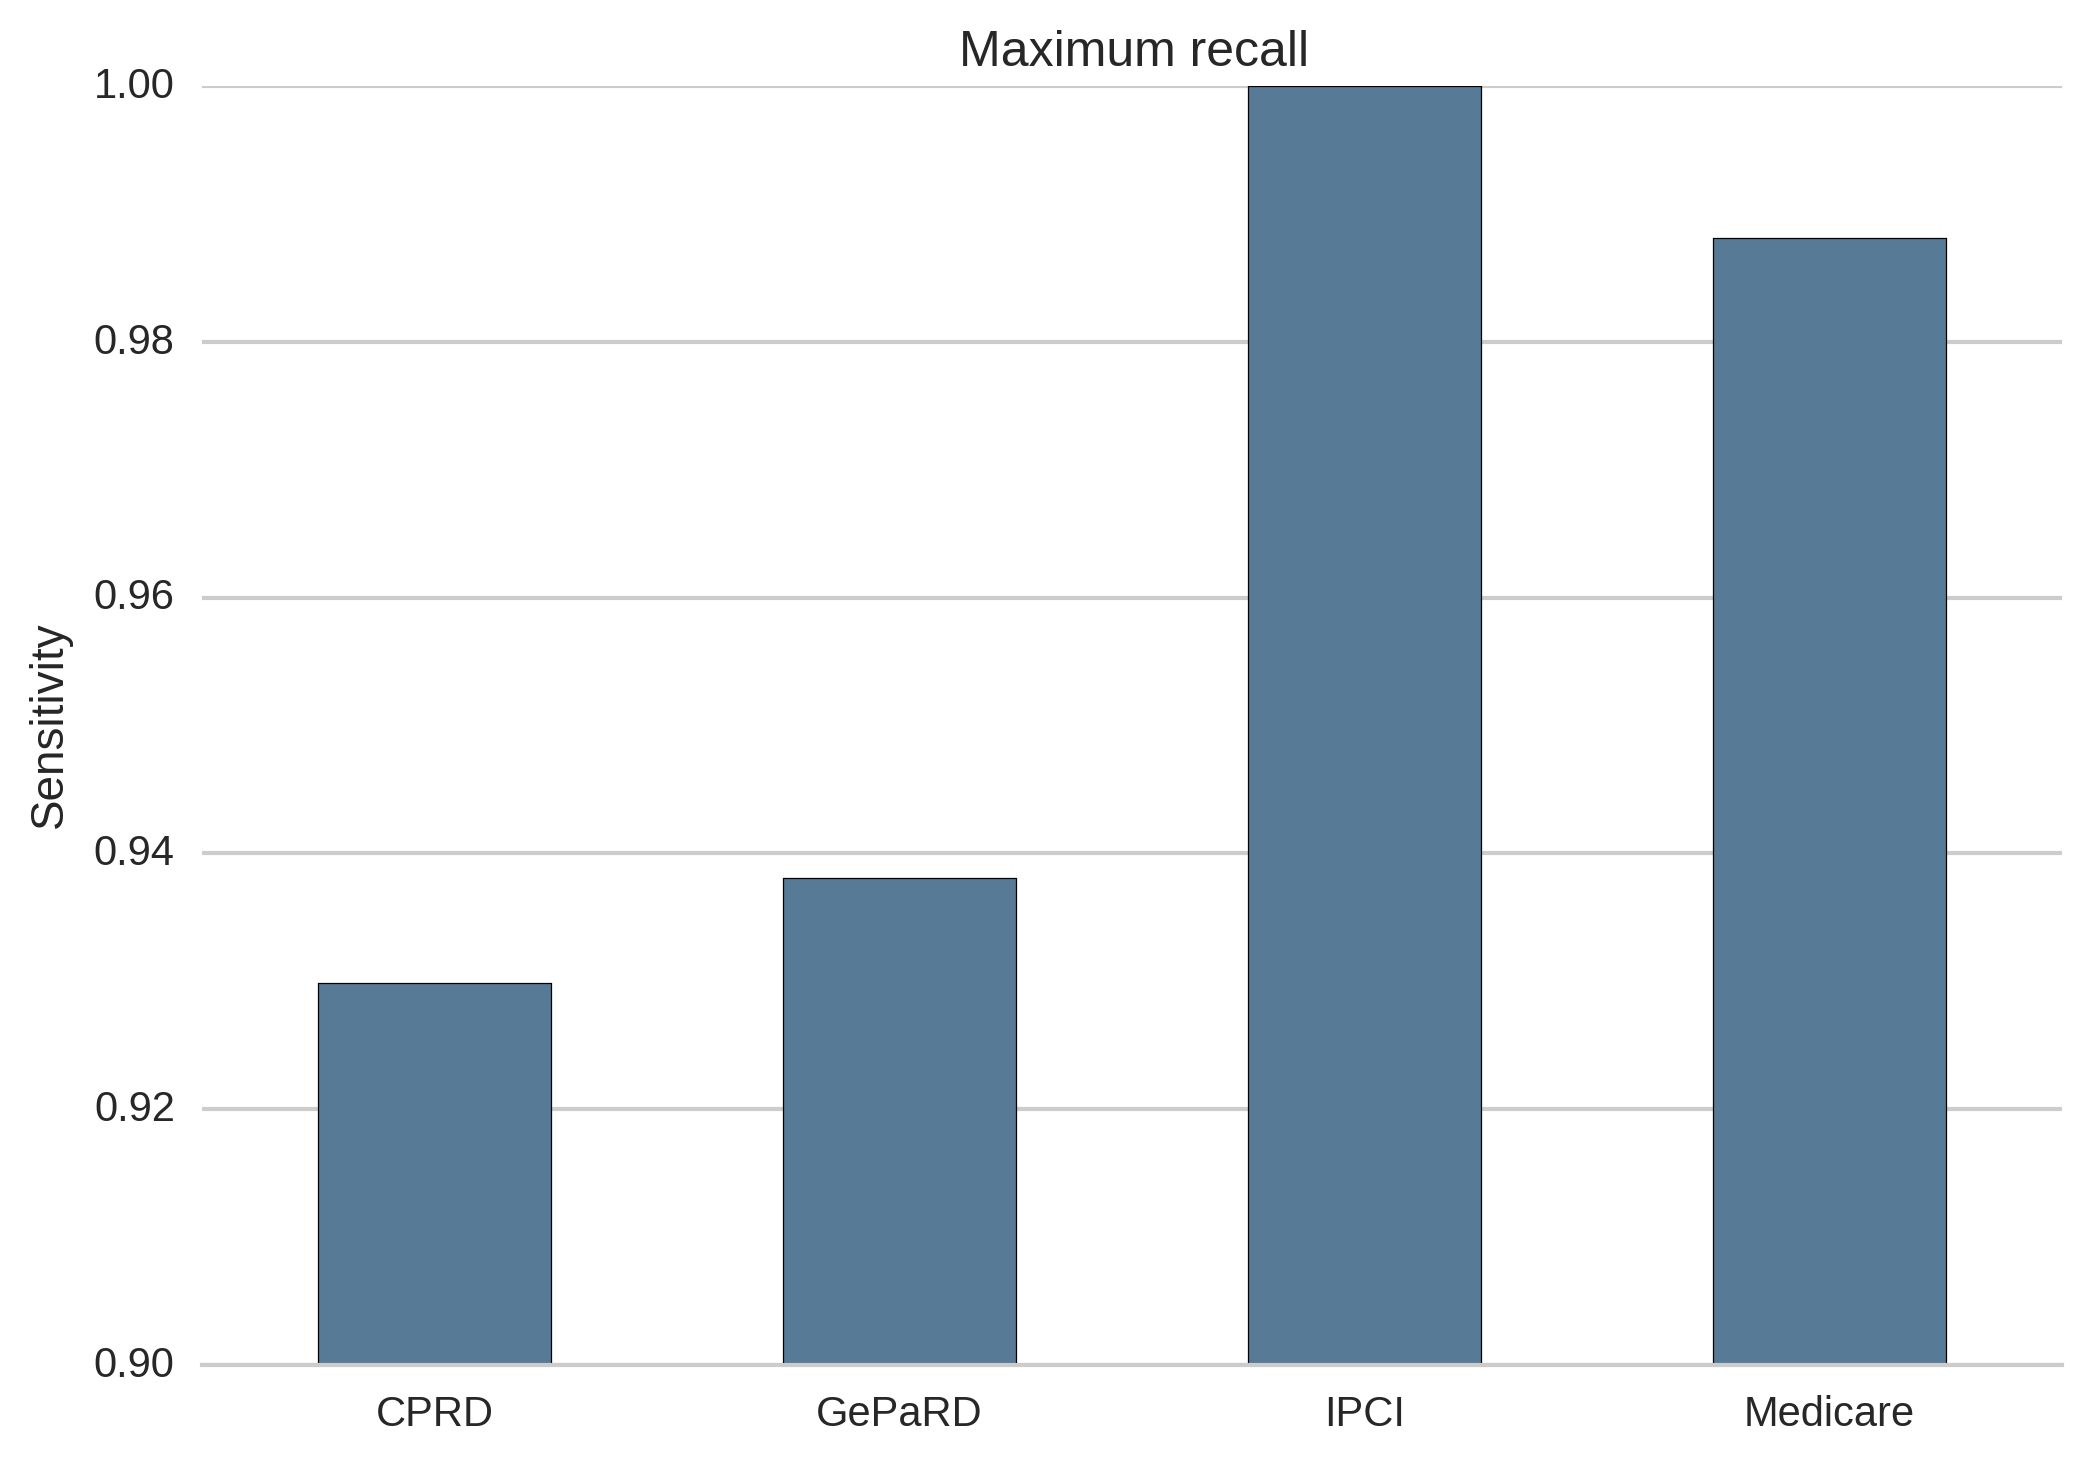

In [7]:
averages_compare = pd.DataFrame([
    df[df.variation == 'max-recall'].groupby('database').recall.mean(),
])
averages_compare.index = [measure_label('recall')]
averages_compare.columns = averages_compare.columns.map(database_label)
with mystyle(measures_palette, ylim=(.9,1)):
    averages_compare.T.plot(kind='bar', legend=False, title='Maximum recall')
    plt.ylabel(measure_label('recall'))
averages_compare

## Reasons for imperfect sensitivity

In [89]:
stats = DataFrame()
stats['In mapping'] = code_stats[code_stats.InMapping]\
    .groupby('Database').Code.count()
stats['Not in maximum recall'] = code_stats[code_stats.InMapping & ~code_stats.InDnf]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats['%'] = (stats['Not in maximum recall'] / stats['In mapping']).map("{:.2%}".format)
stats['Not in maximum recall but in database'] = code_stats[code_stats.InMapping & code_stats.InDatabase & ~code_stats.InDnf]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats

,In mapping,Not in maximum recall,%,Not in maximum recall but in database
Database,,,,
CPRD,229,14,6.11%,14
GePaRD,74,3,4.05%,3
IPCI,16,0,0.00%,0
Medicare,53,1,1.89%,0


In [87]:
max_recall_fn = df0[(df0.variation == 'max-recall') & (df0.recall < 1)][["database", "fn"]]
max_recall_fn.database = max_recall_fn.database.map(database_label)
max_recall_fn.fn = max_recall_fn.fn.fillna('[]').map(json.loads)
max_recall_fn = max_recall_fn.groupby('database').fn.sum().to_frame()
max_recall_fn.fn = max_recall_fn.fn.map(set).map(', '.join)
max_recall_fn.index.name = 'Database'
max_recall_fn.columns = ['False negatives']
max_recall_fn

,False negatives
Database,
CPRD,"7L1H6, G6X.., BBaz., 7L1H7, ByuE0, 1O0.., BBd9..."
GePaRD,"I21.9, I64, I46.0"
Medicare,410.X2


`CPRD`: READ2 codes from the reference are mapped to READ CTV3 codes that are not in UMLS, for example `7L1H6` (READ2) -> `XaM3E`, `XaPuP`, `7L1H6`, `7L1h6`.

`GePaRD`: Only 3 codes are missing, but those FN have large influence on sensitivity in mappings with few codes.

,Sensitivity
Acute Pancreatitis,1.000000
Bladder cancer,0.980769
Hemorrhagic stroke,0.986111
Ischemic stroke,0.939773
Myocardial Infarction,0.924603
Pancreatic Cancer,0.983945
Ventricular Arrhythmia,0.931481


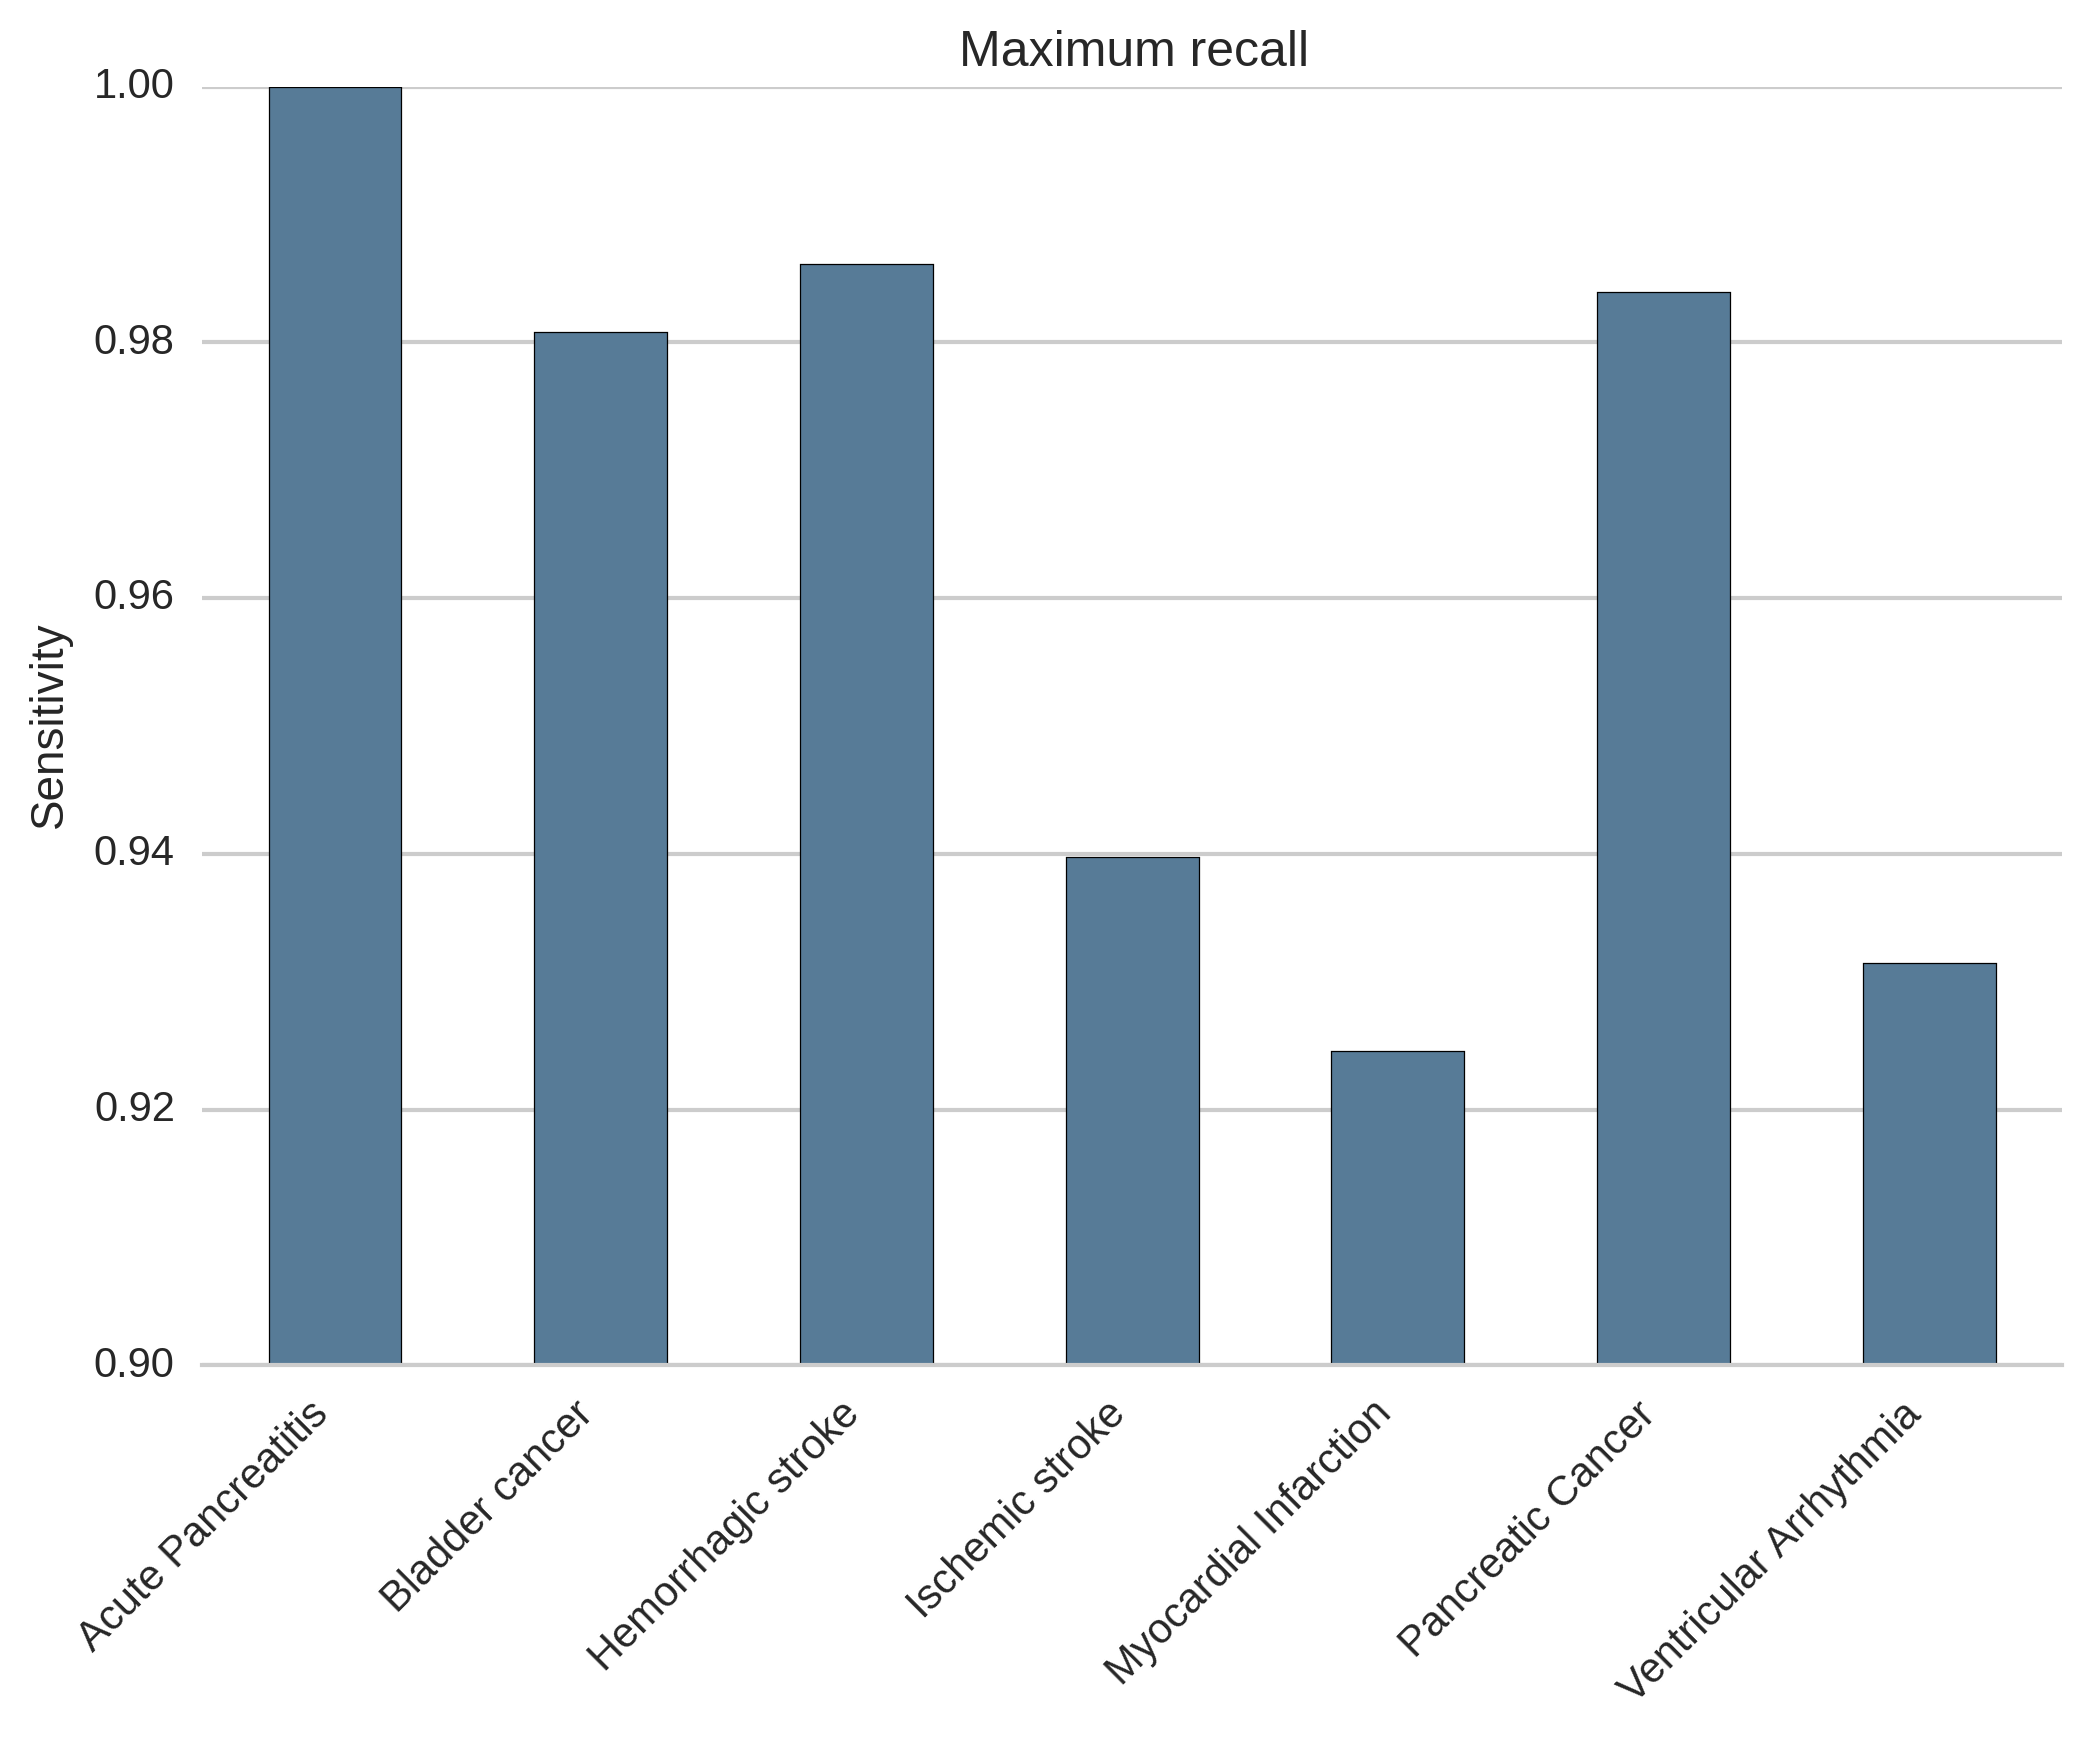

In [8]:
averages = df[df.variation == 'max-recall'].groupby('event').recall.mean()
averages.name = measure_label('recall')
averages.index = averages.index.map(event_names.get)
with mystyle(measures_palette, xrot=45, ha='right', ylim=(0.9,1)):
    averages.plot(kind='bar', legend=False, title="Maximum recall")
    plt.ylabel(measure_label('recall'))
averages.to_frame()

# Compare relations for expansion

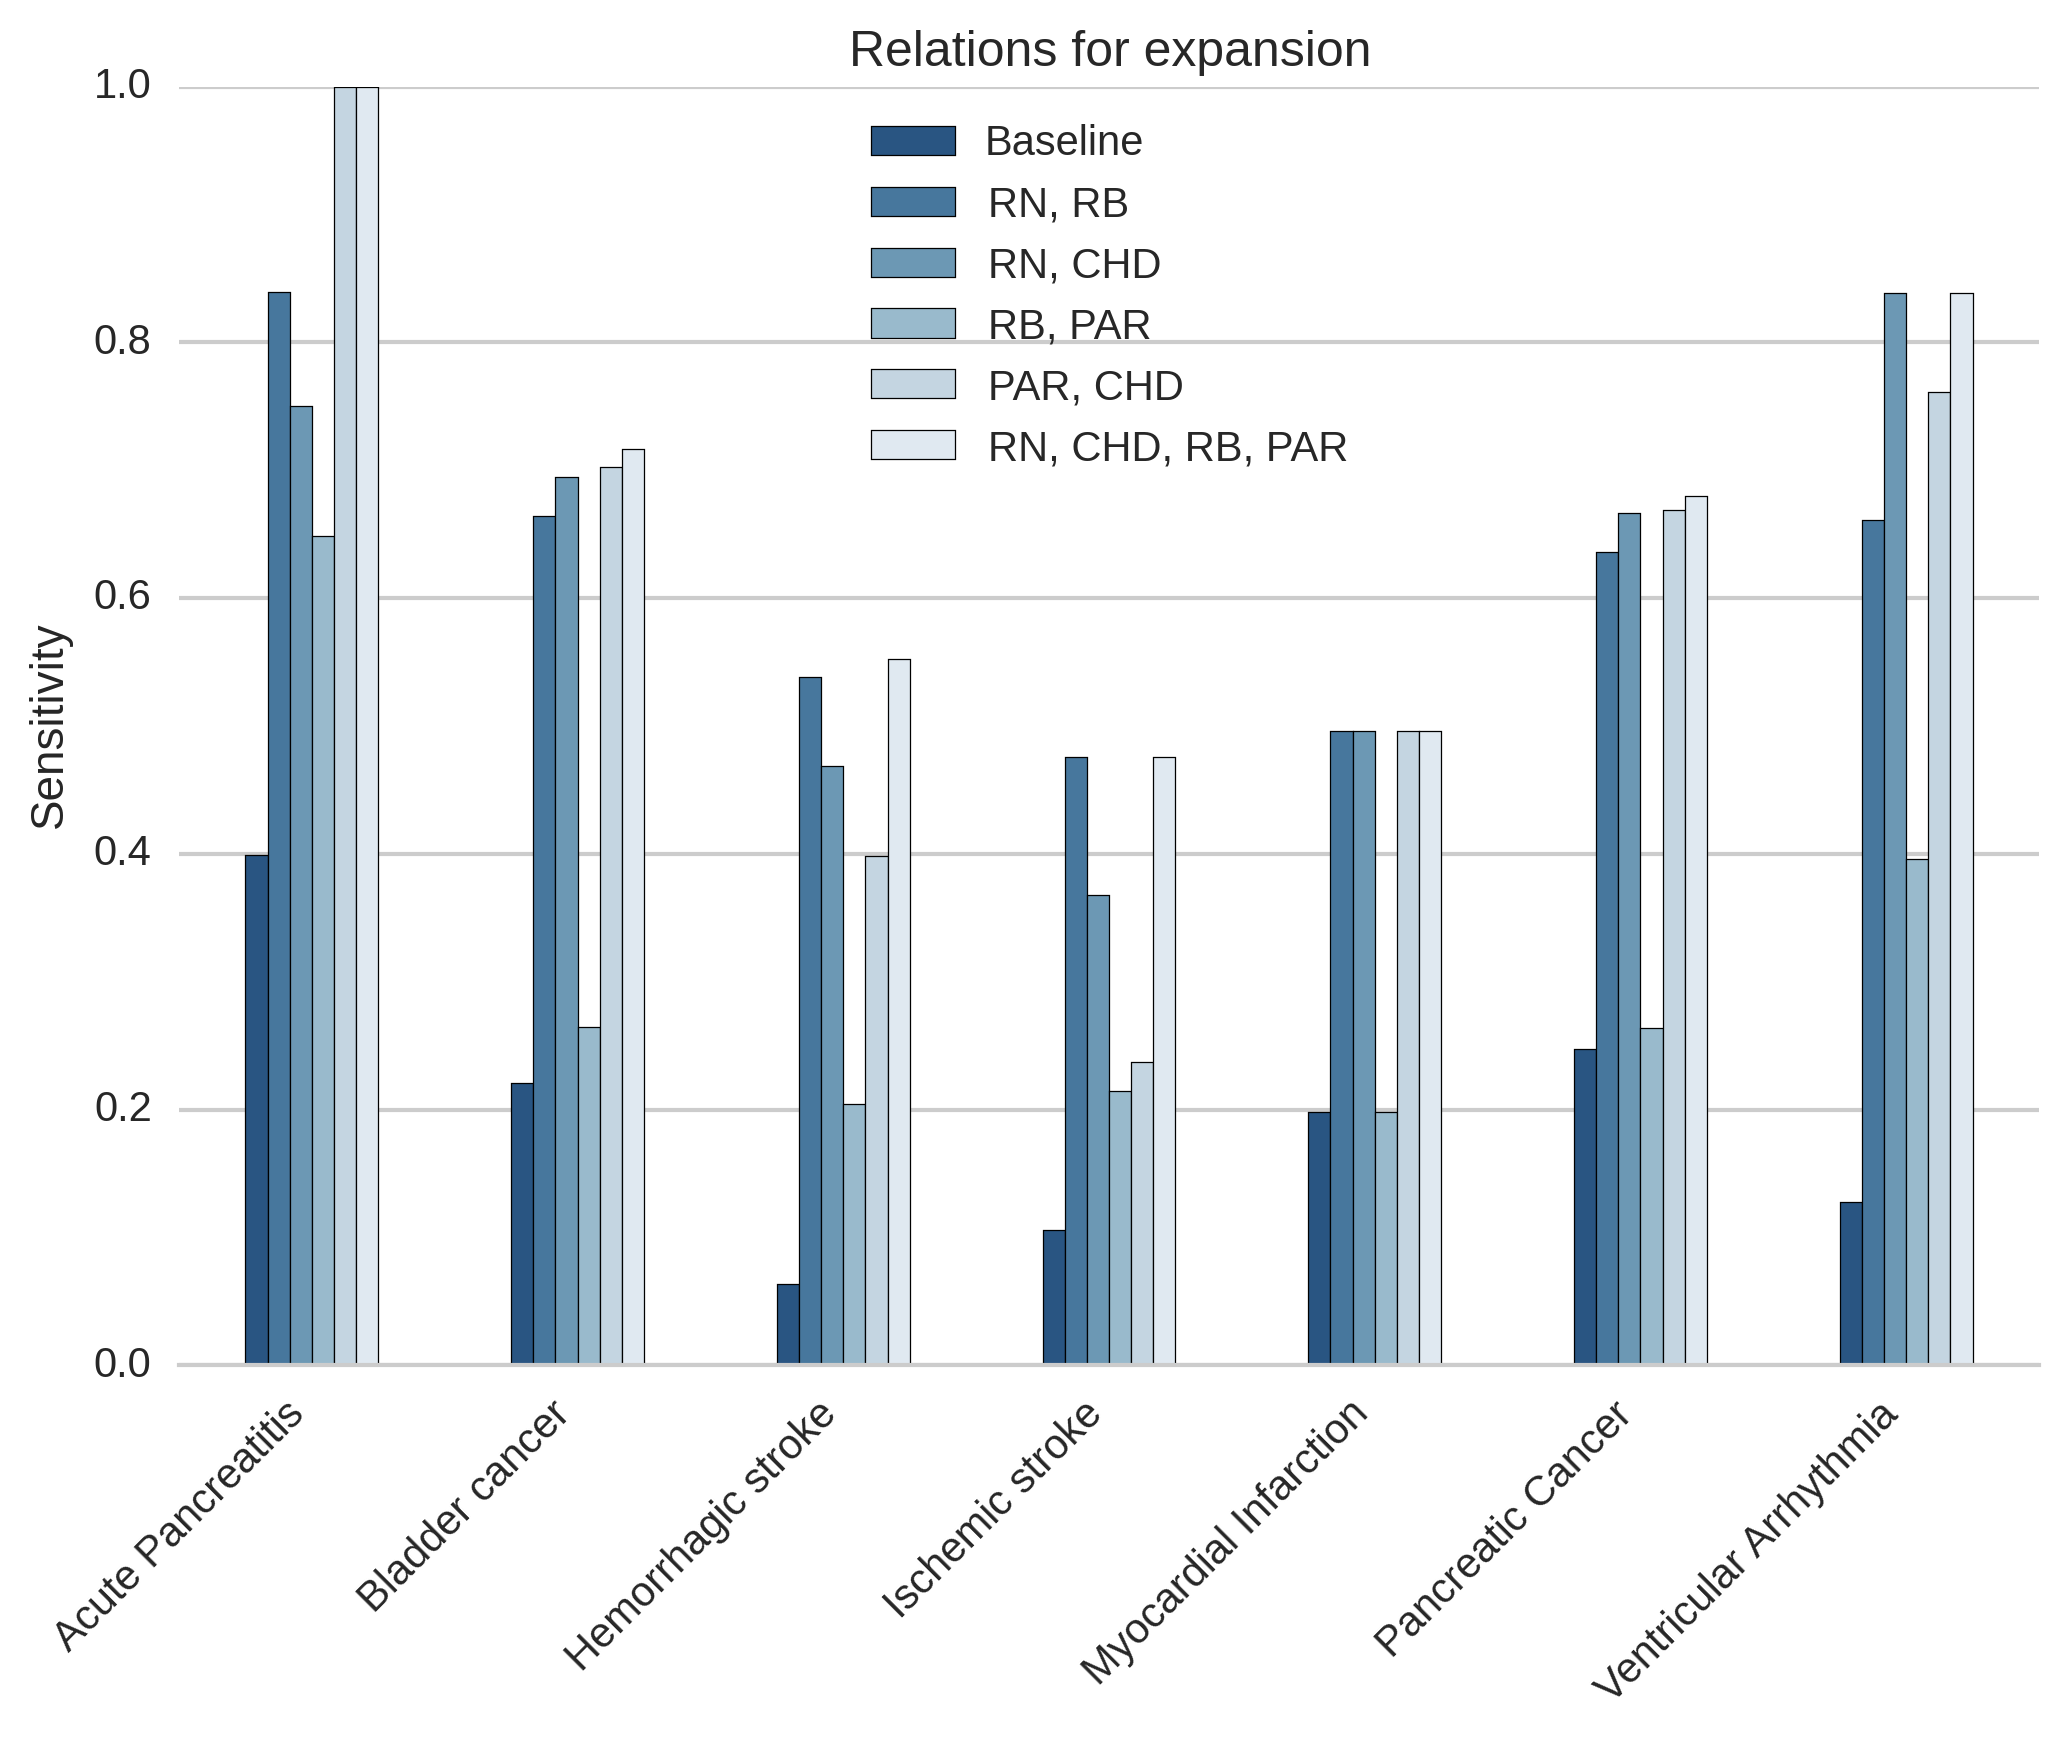

In [9]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Relations for expansion")
    plt.ylabel(measure_label('recall'))

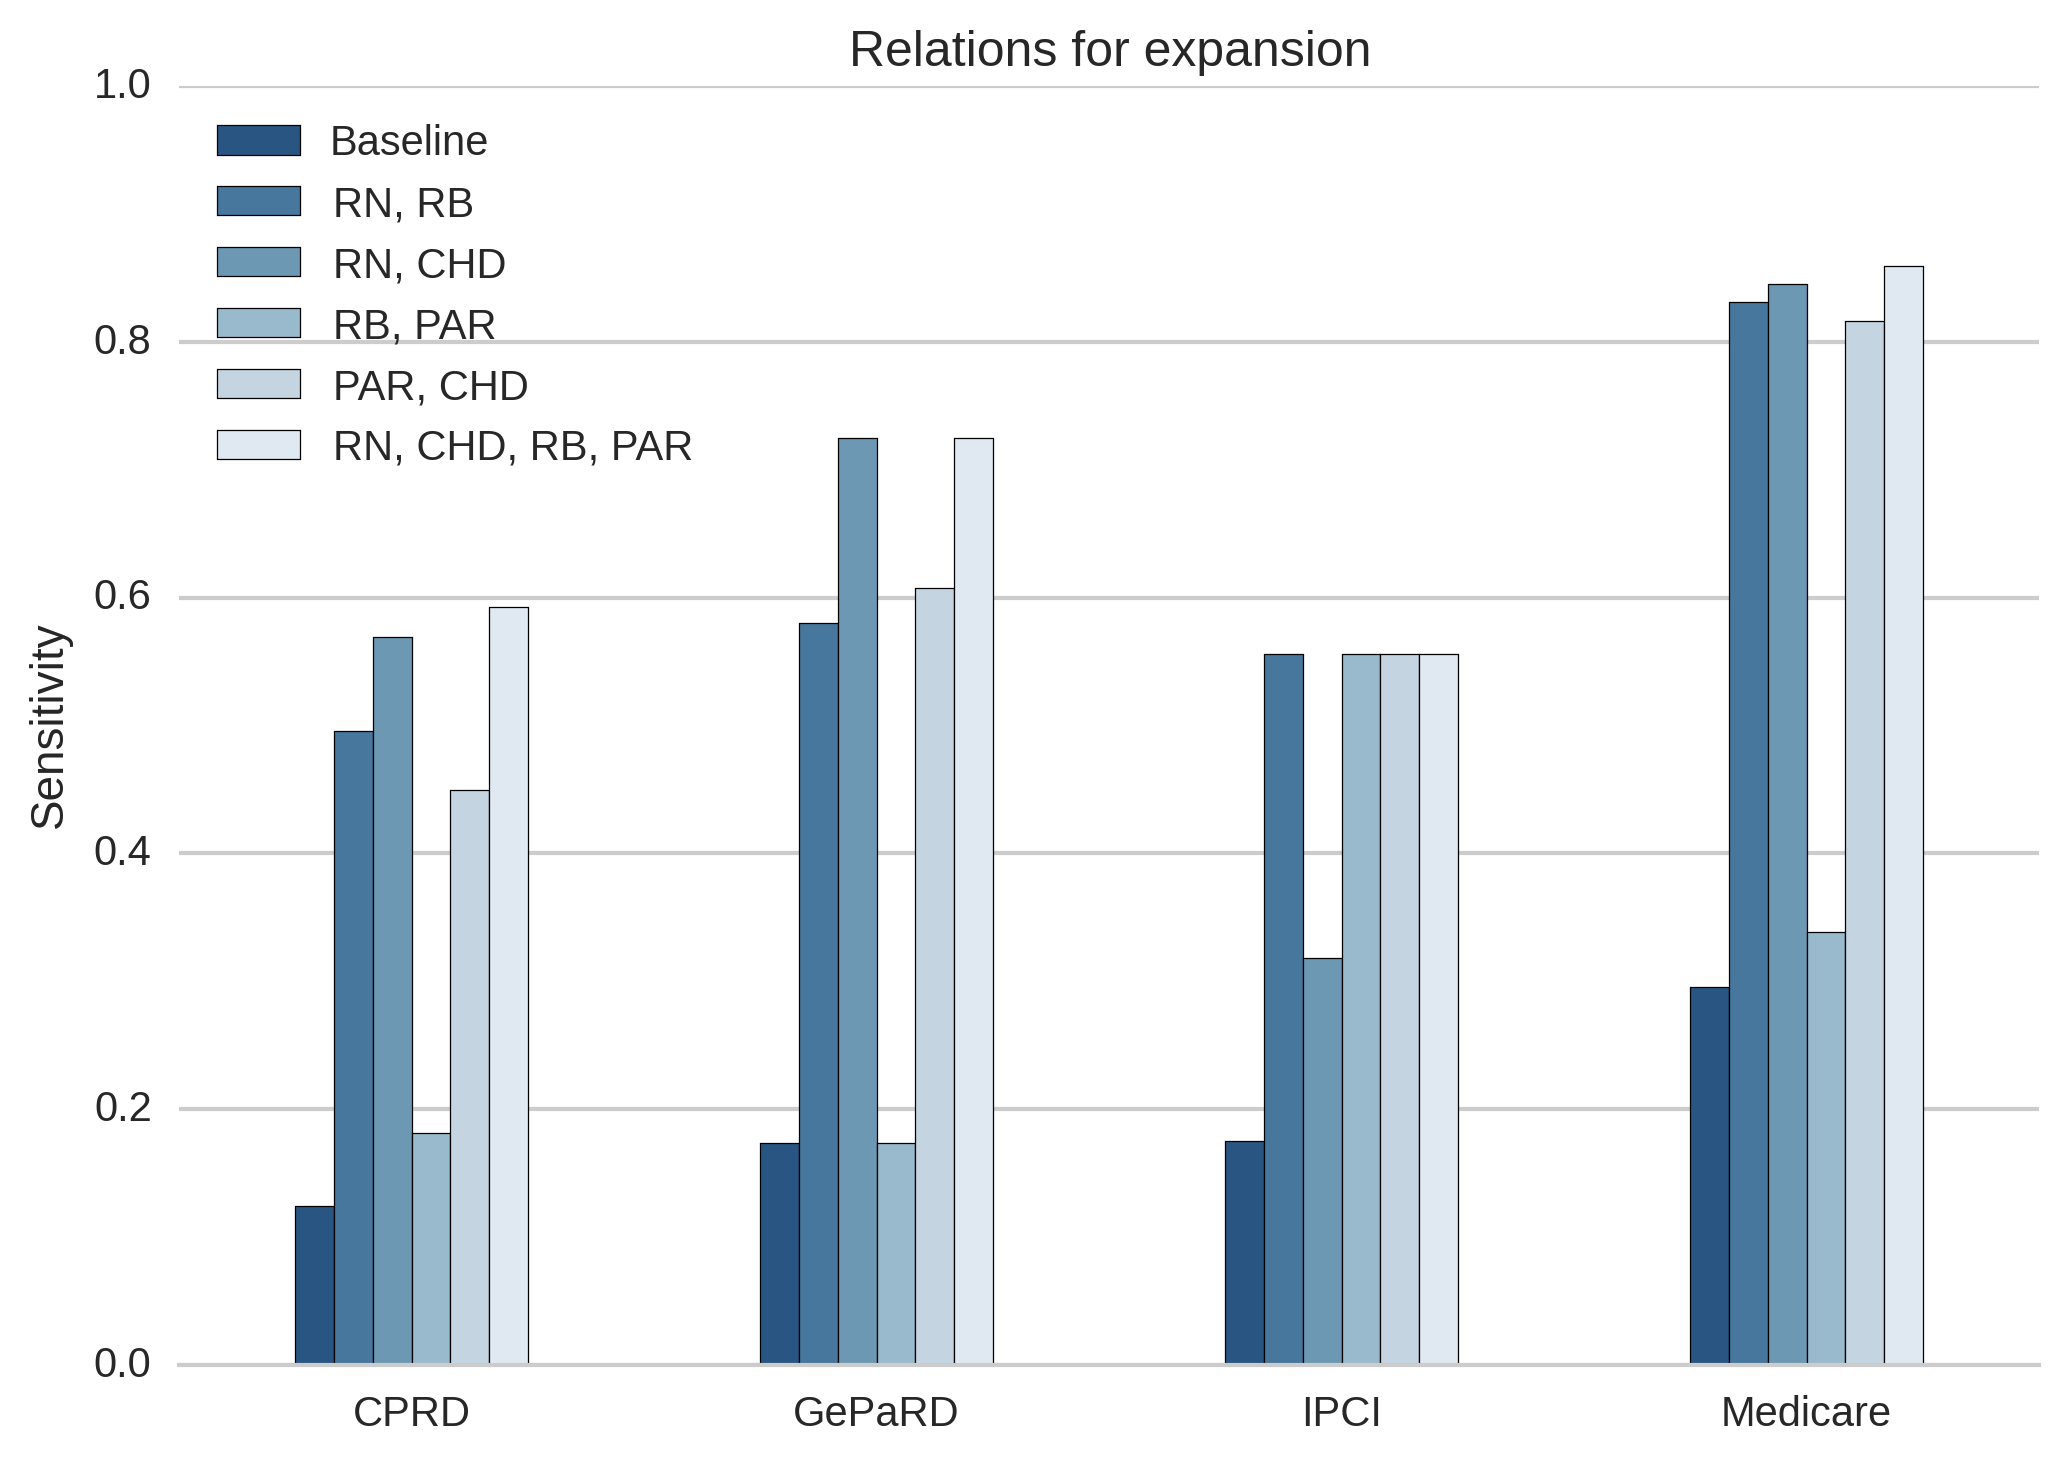

In [10]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-RB.expand', 'RN, RB'),
    ('1-RN-CHD.expand', 'RN, CHD'),
    ('1-RB-PAR.expand', 'RB, PAR'),
    ('1-PAR-CHD.expand', 'PAR, CHD'),
    ('1-RN-CHD-RB-PAR.expand', 'RN, CHD, RB, PAR'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()
with mystyle(graded_recall_palette(len(compare_variations))):
    averages_compare.T.plot(kind='bar', title="Relations for expansion")
    plt.ylabel(measure_label('recall'))

# Increasing sensitivity with more expansion steps

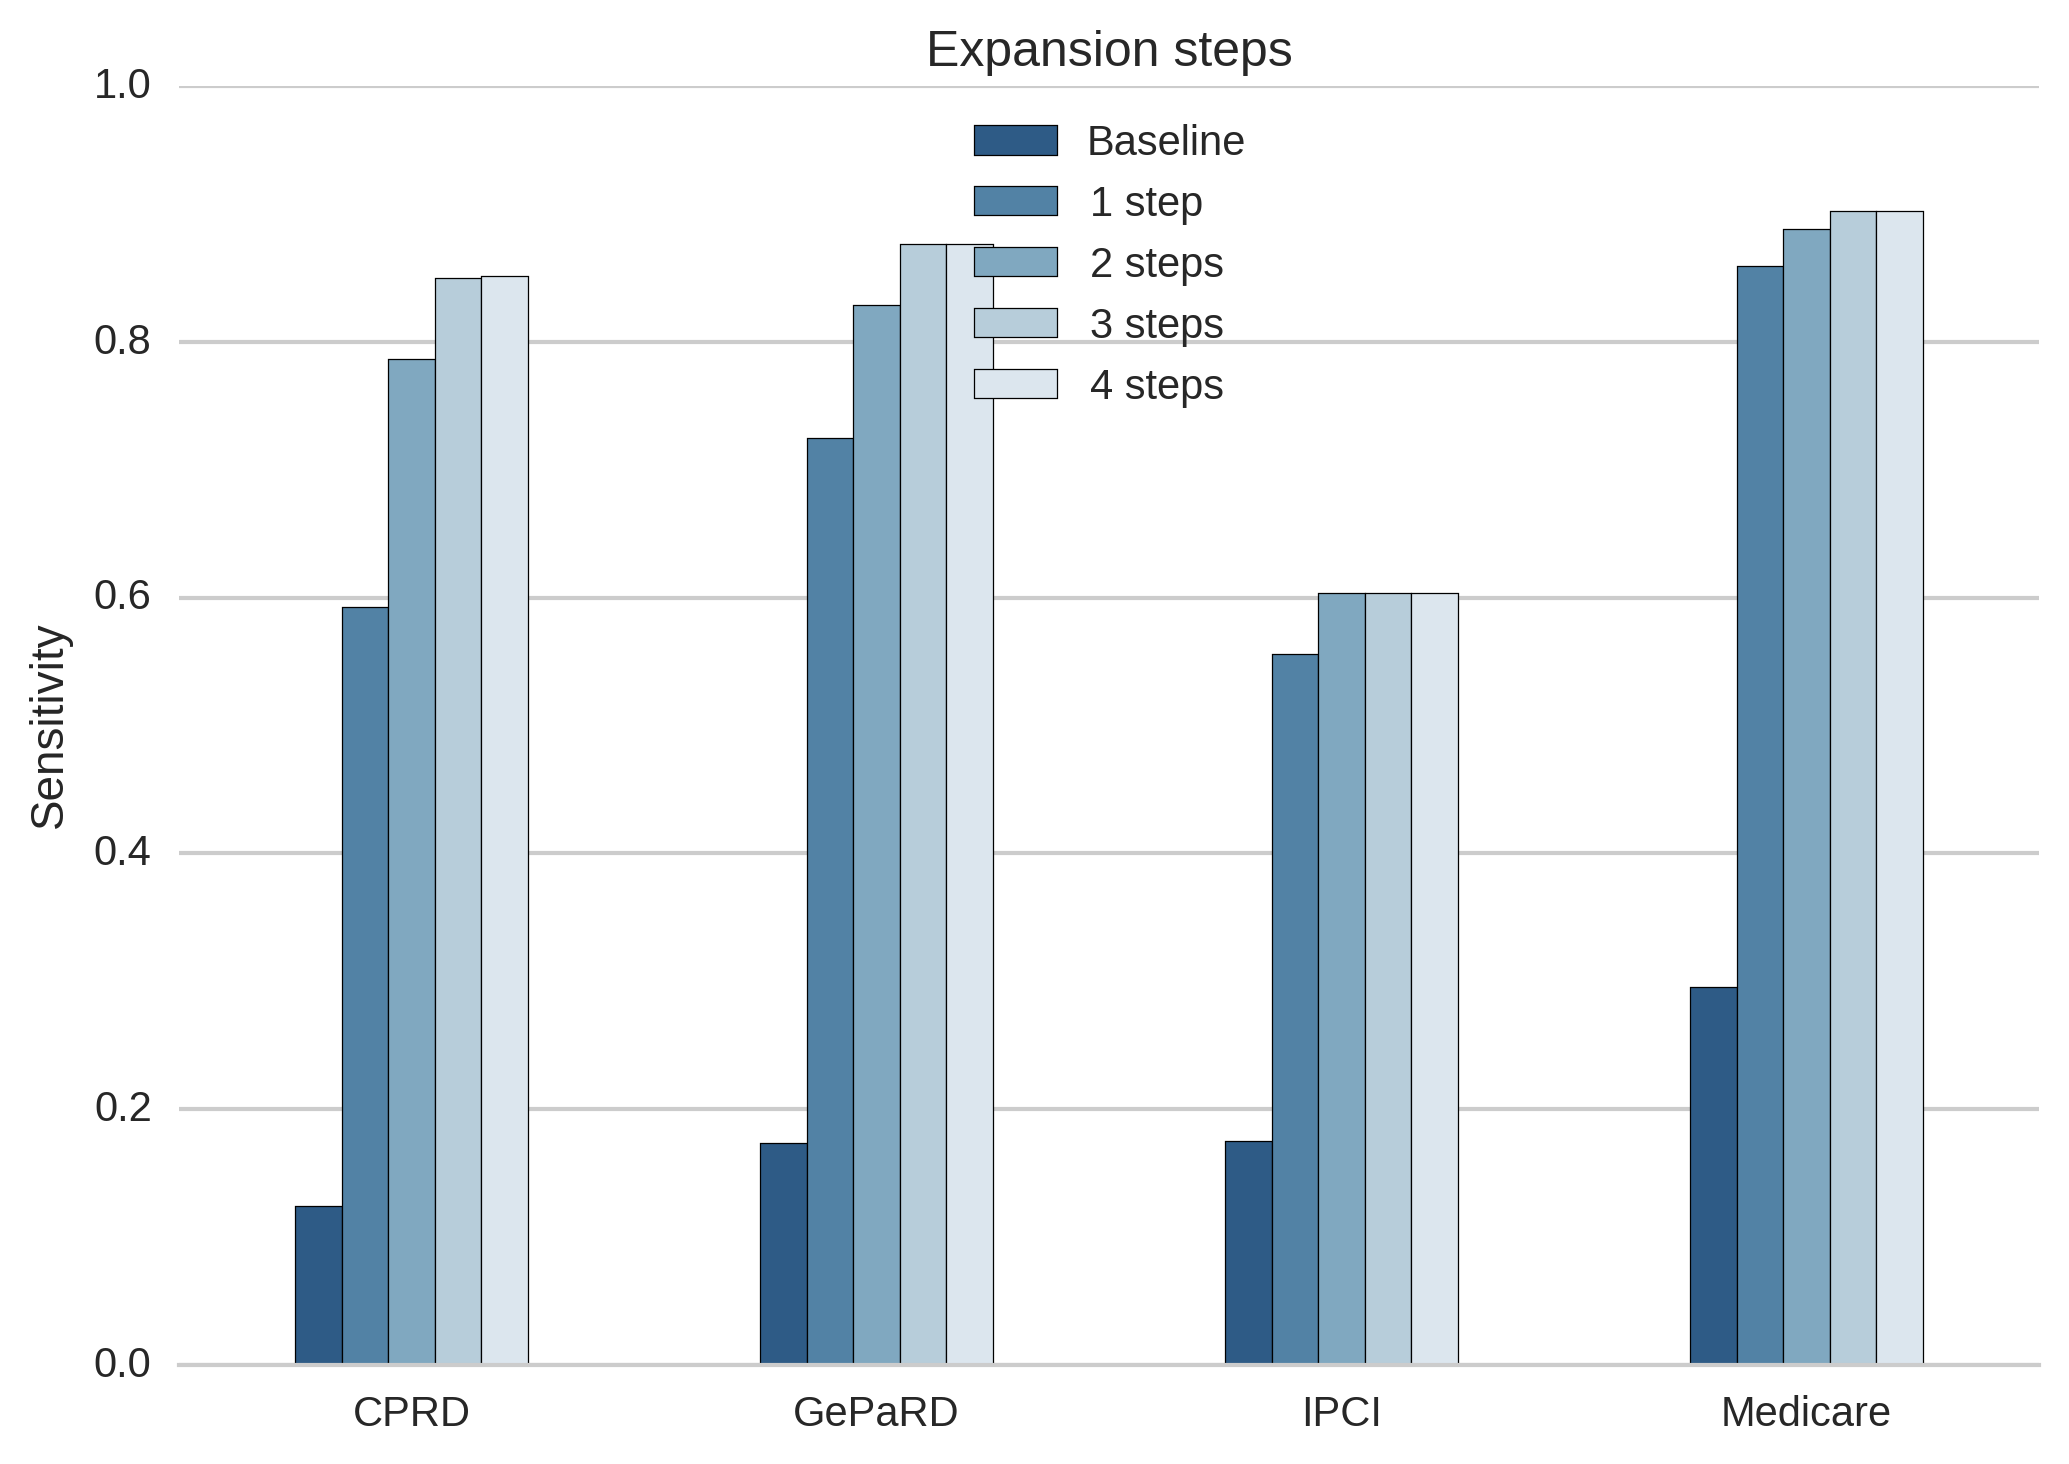

In [11]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()

with mystyle(graded_recall_palette(len(compare_variations))):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('recall'))

## Reasons for low performance in IPCI

The IPCI mapping contains *very* broad codes that are refined with additional terms. For example

- `K24` (Fear of heart attack)
- `K90` (stroke)
- `K93` (Pulmonary embolism)
- `D70` (Dementia) OR "dementia" AND "infarct"
- `U14` (Kidney symptom/complaint ) OR "nier" AND "infarct"

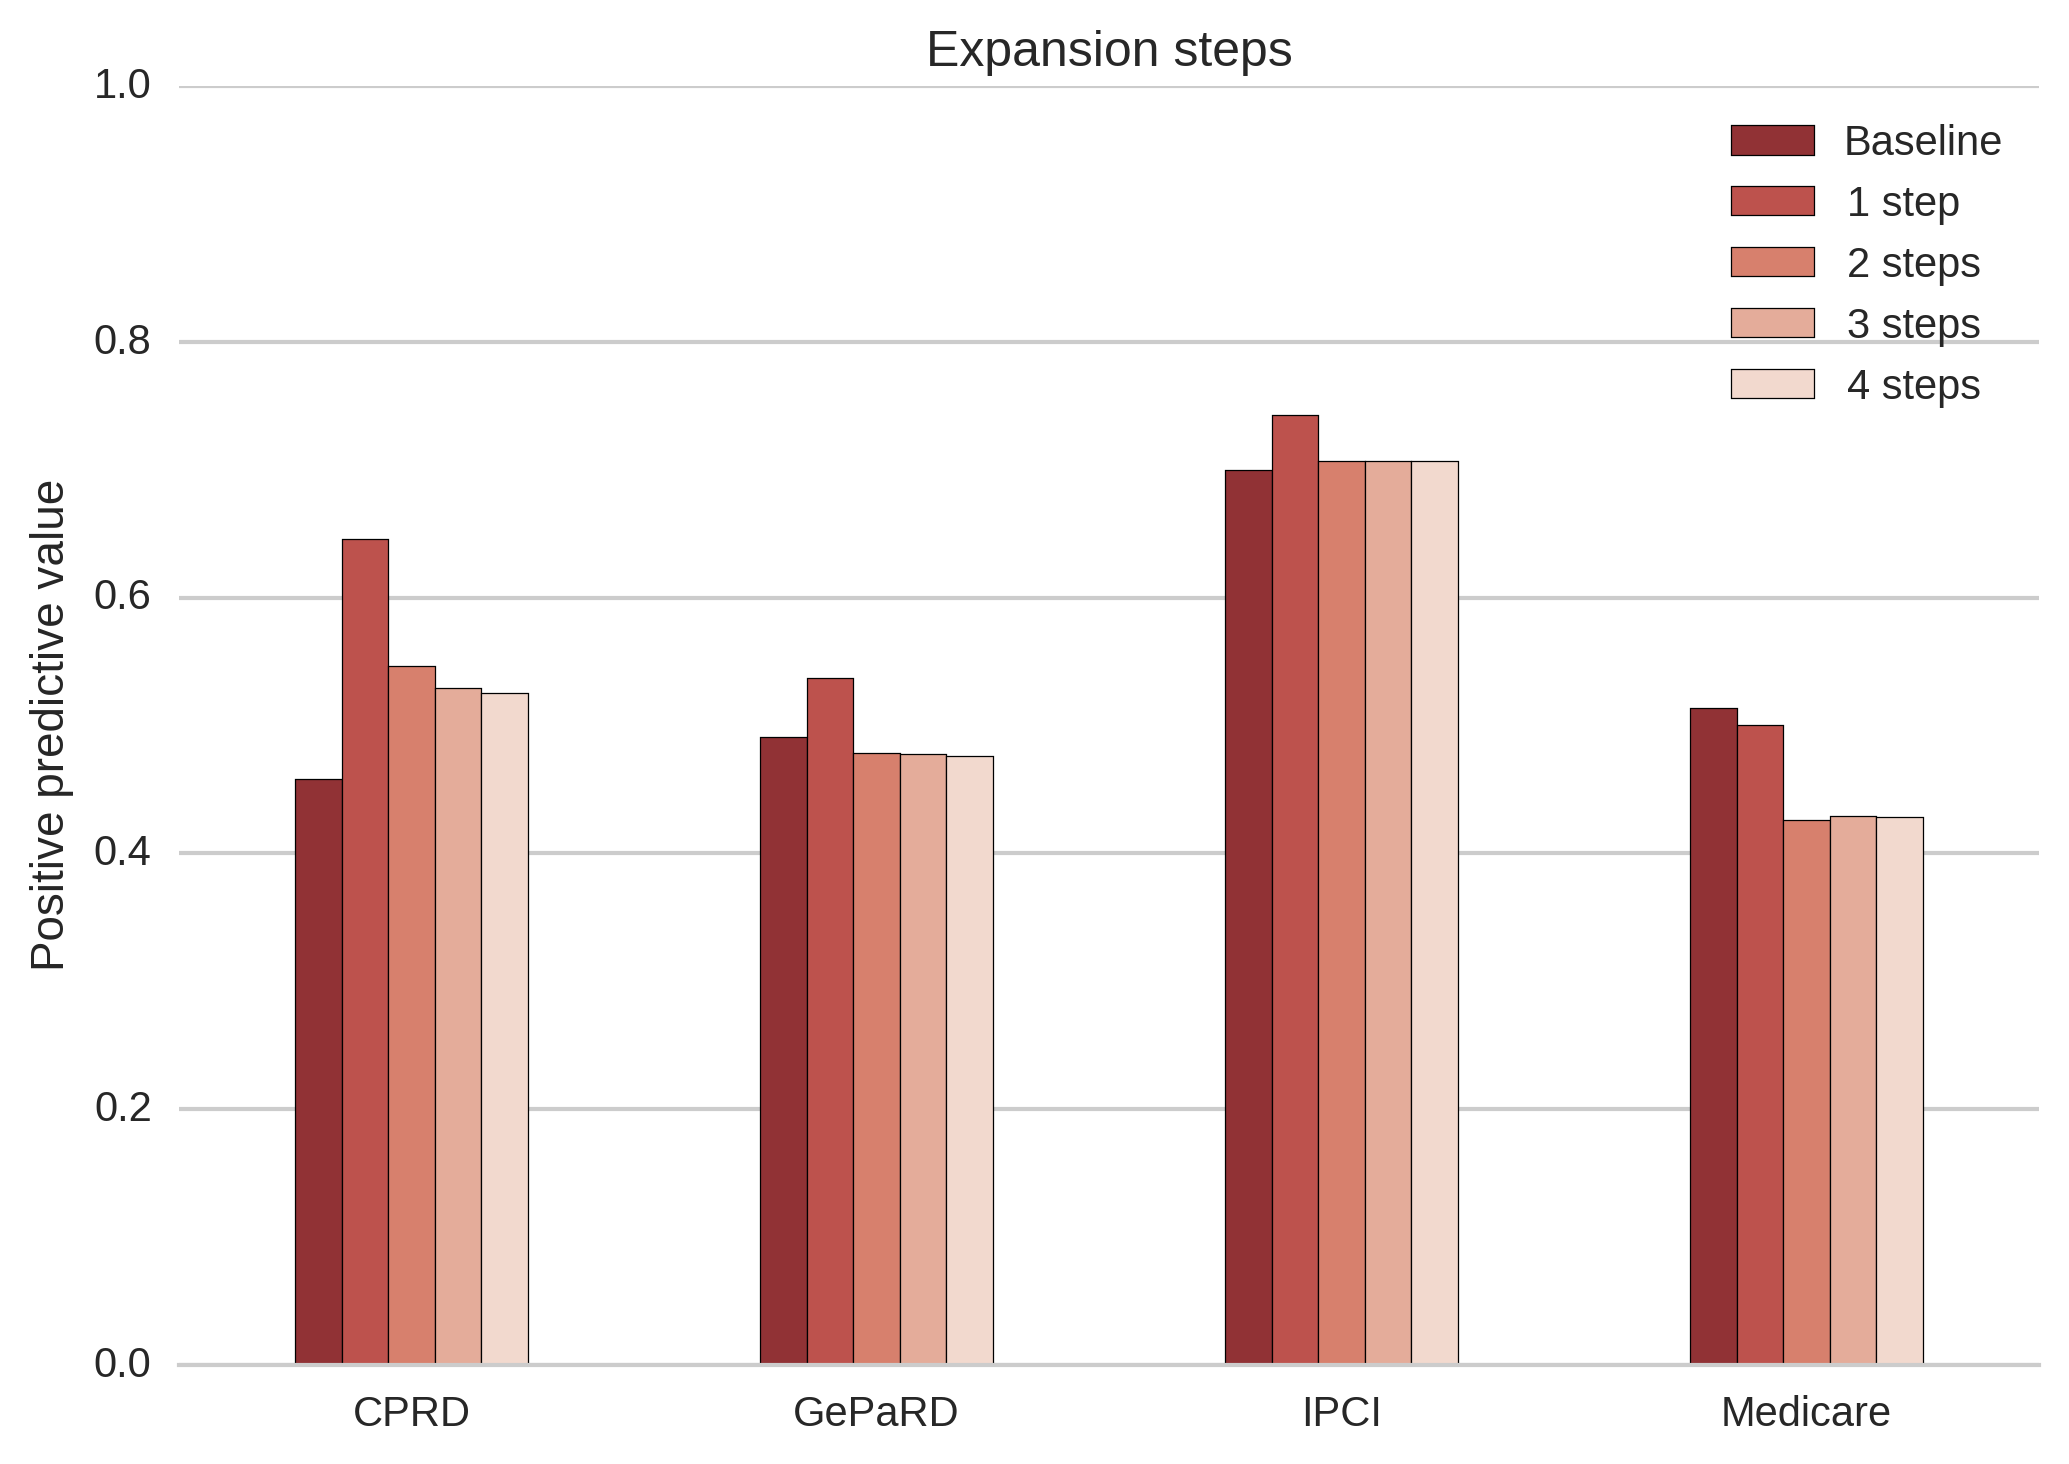

In [12]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(database_label)
averages_compare.index = compare_variations.values()

with mystyle(graded_precision_palette(len(compare_variations))):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('precision'))

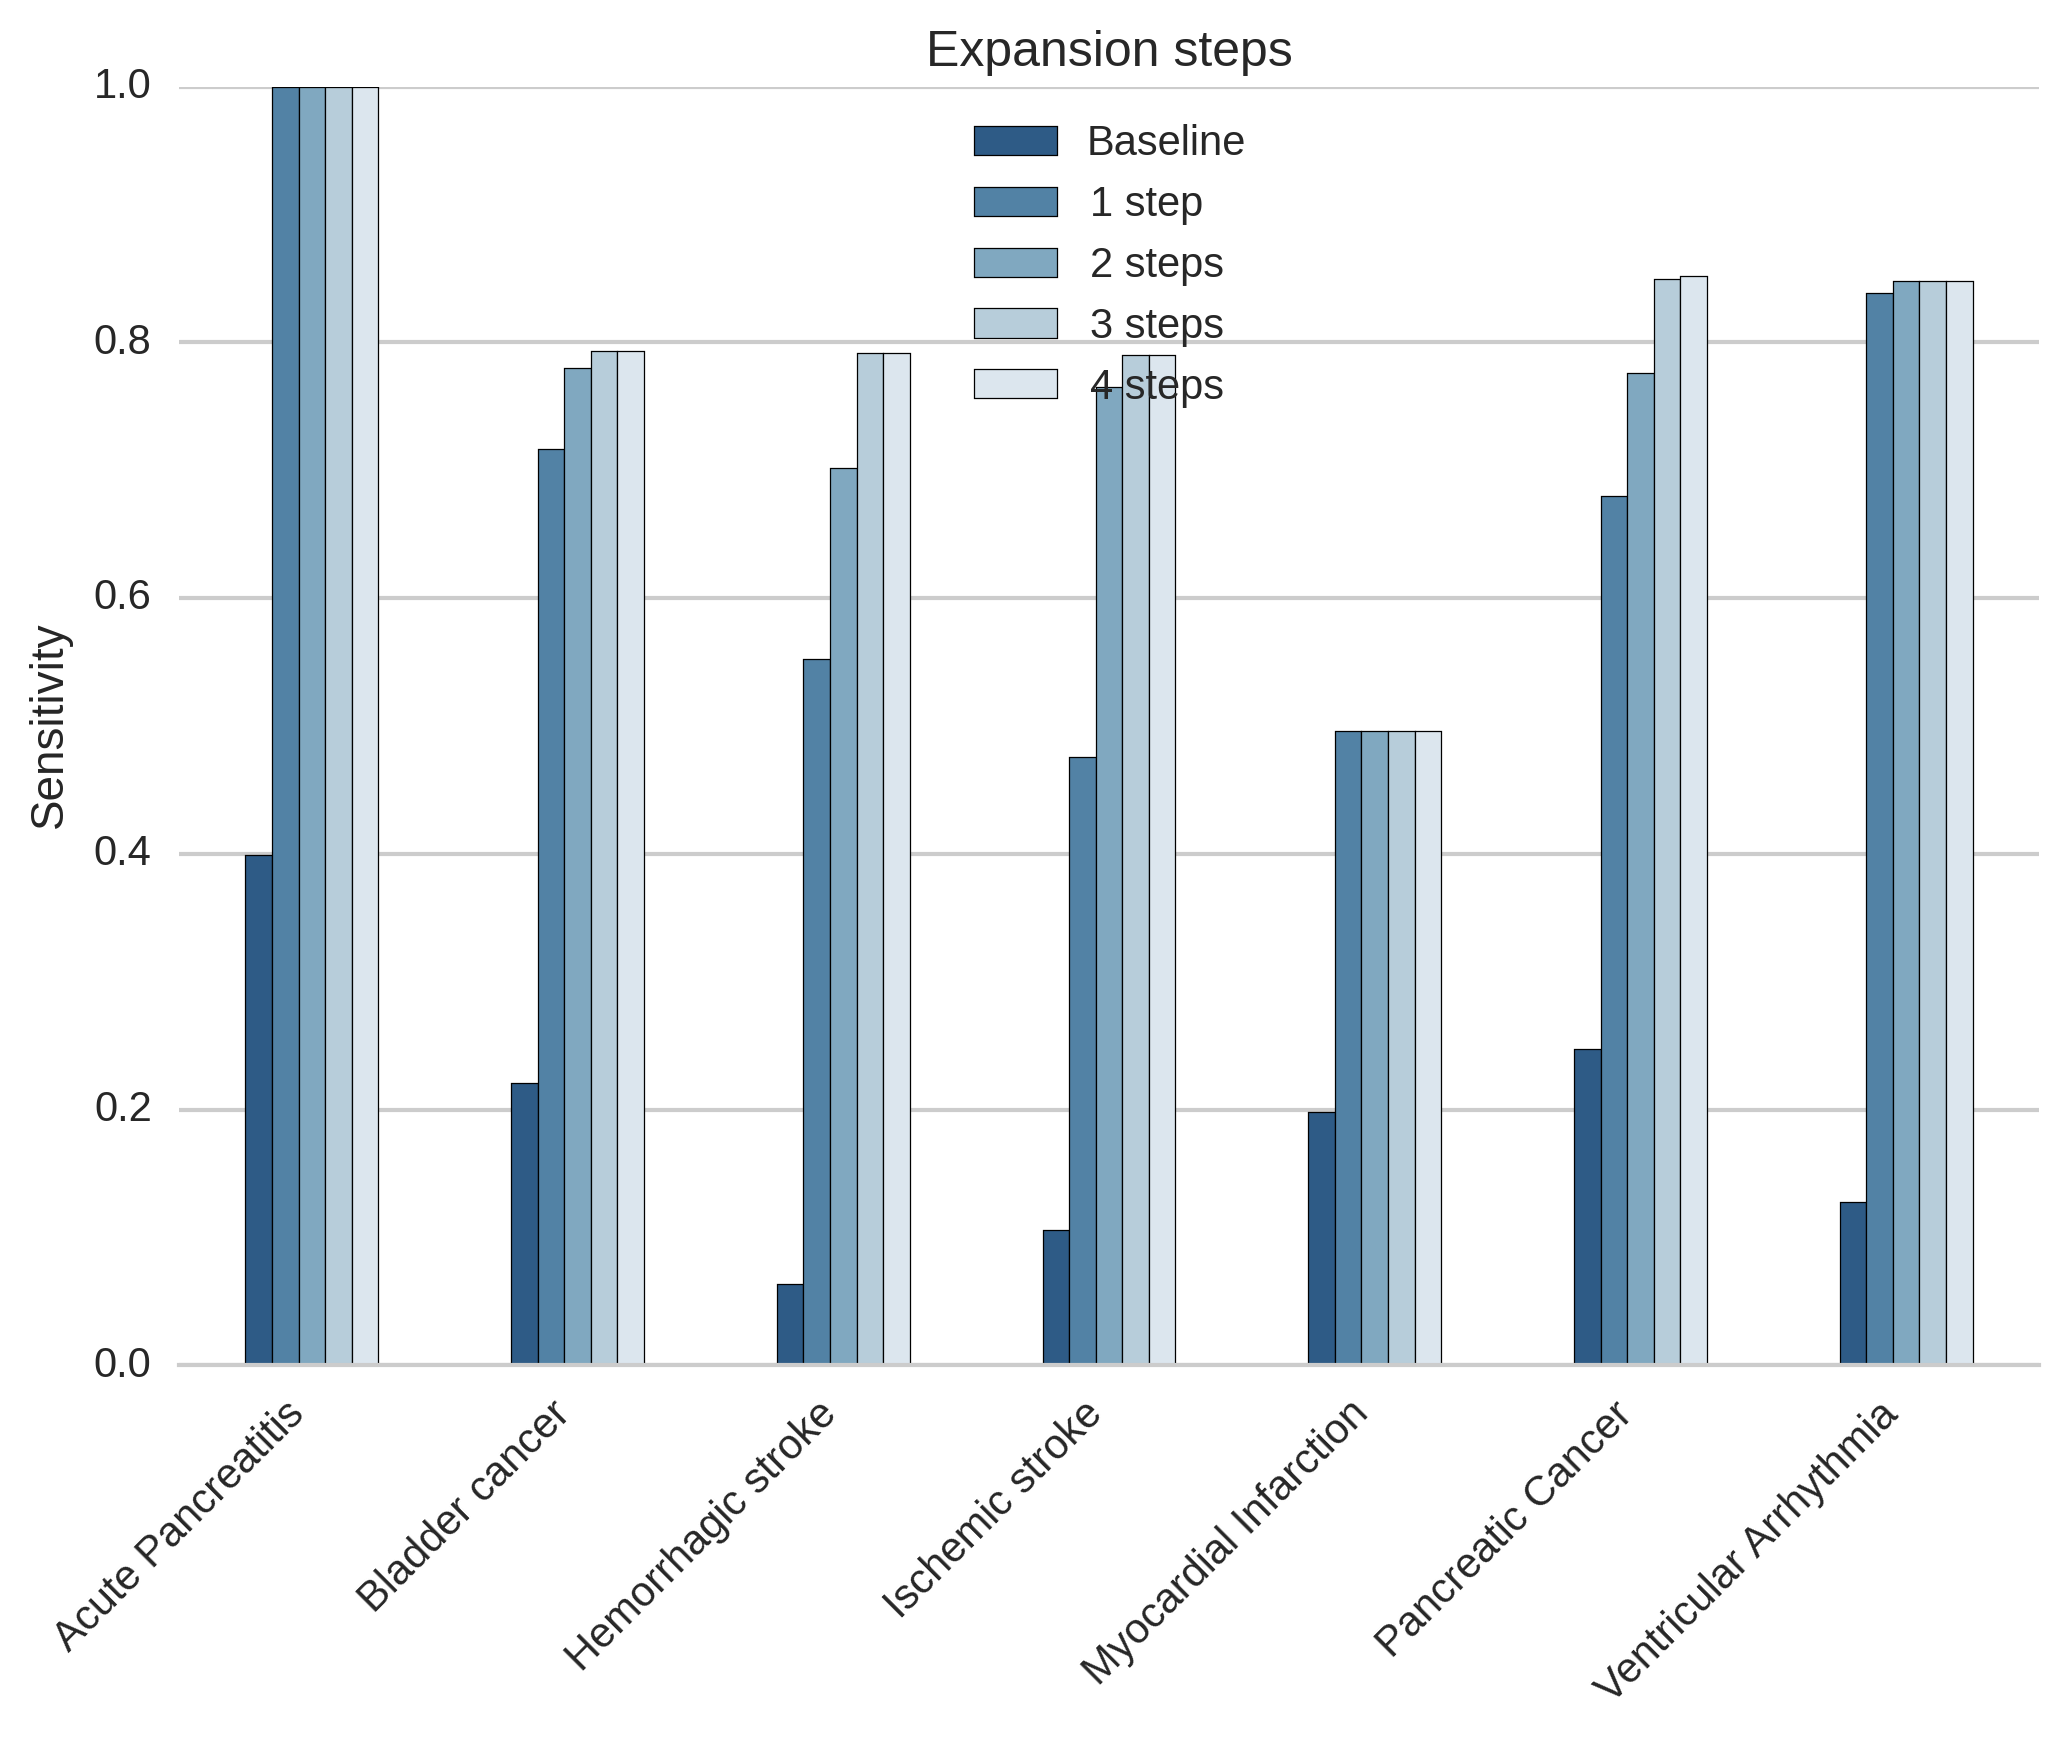

In [13]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').recall.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()

with mystyle(graded_recall_palette(len(compare_variations)), xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('recall'))

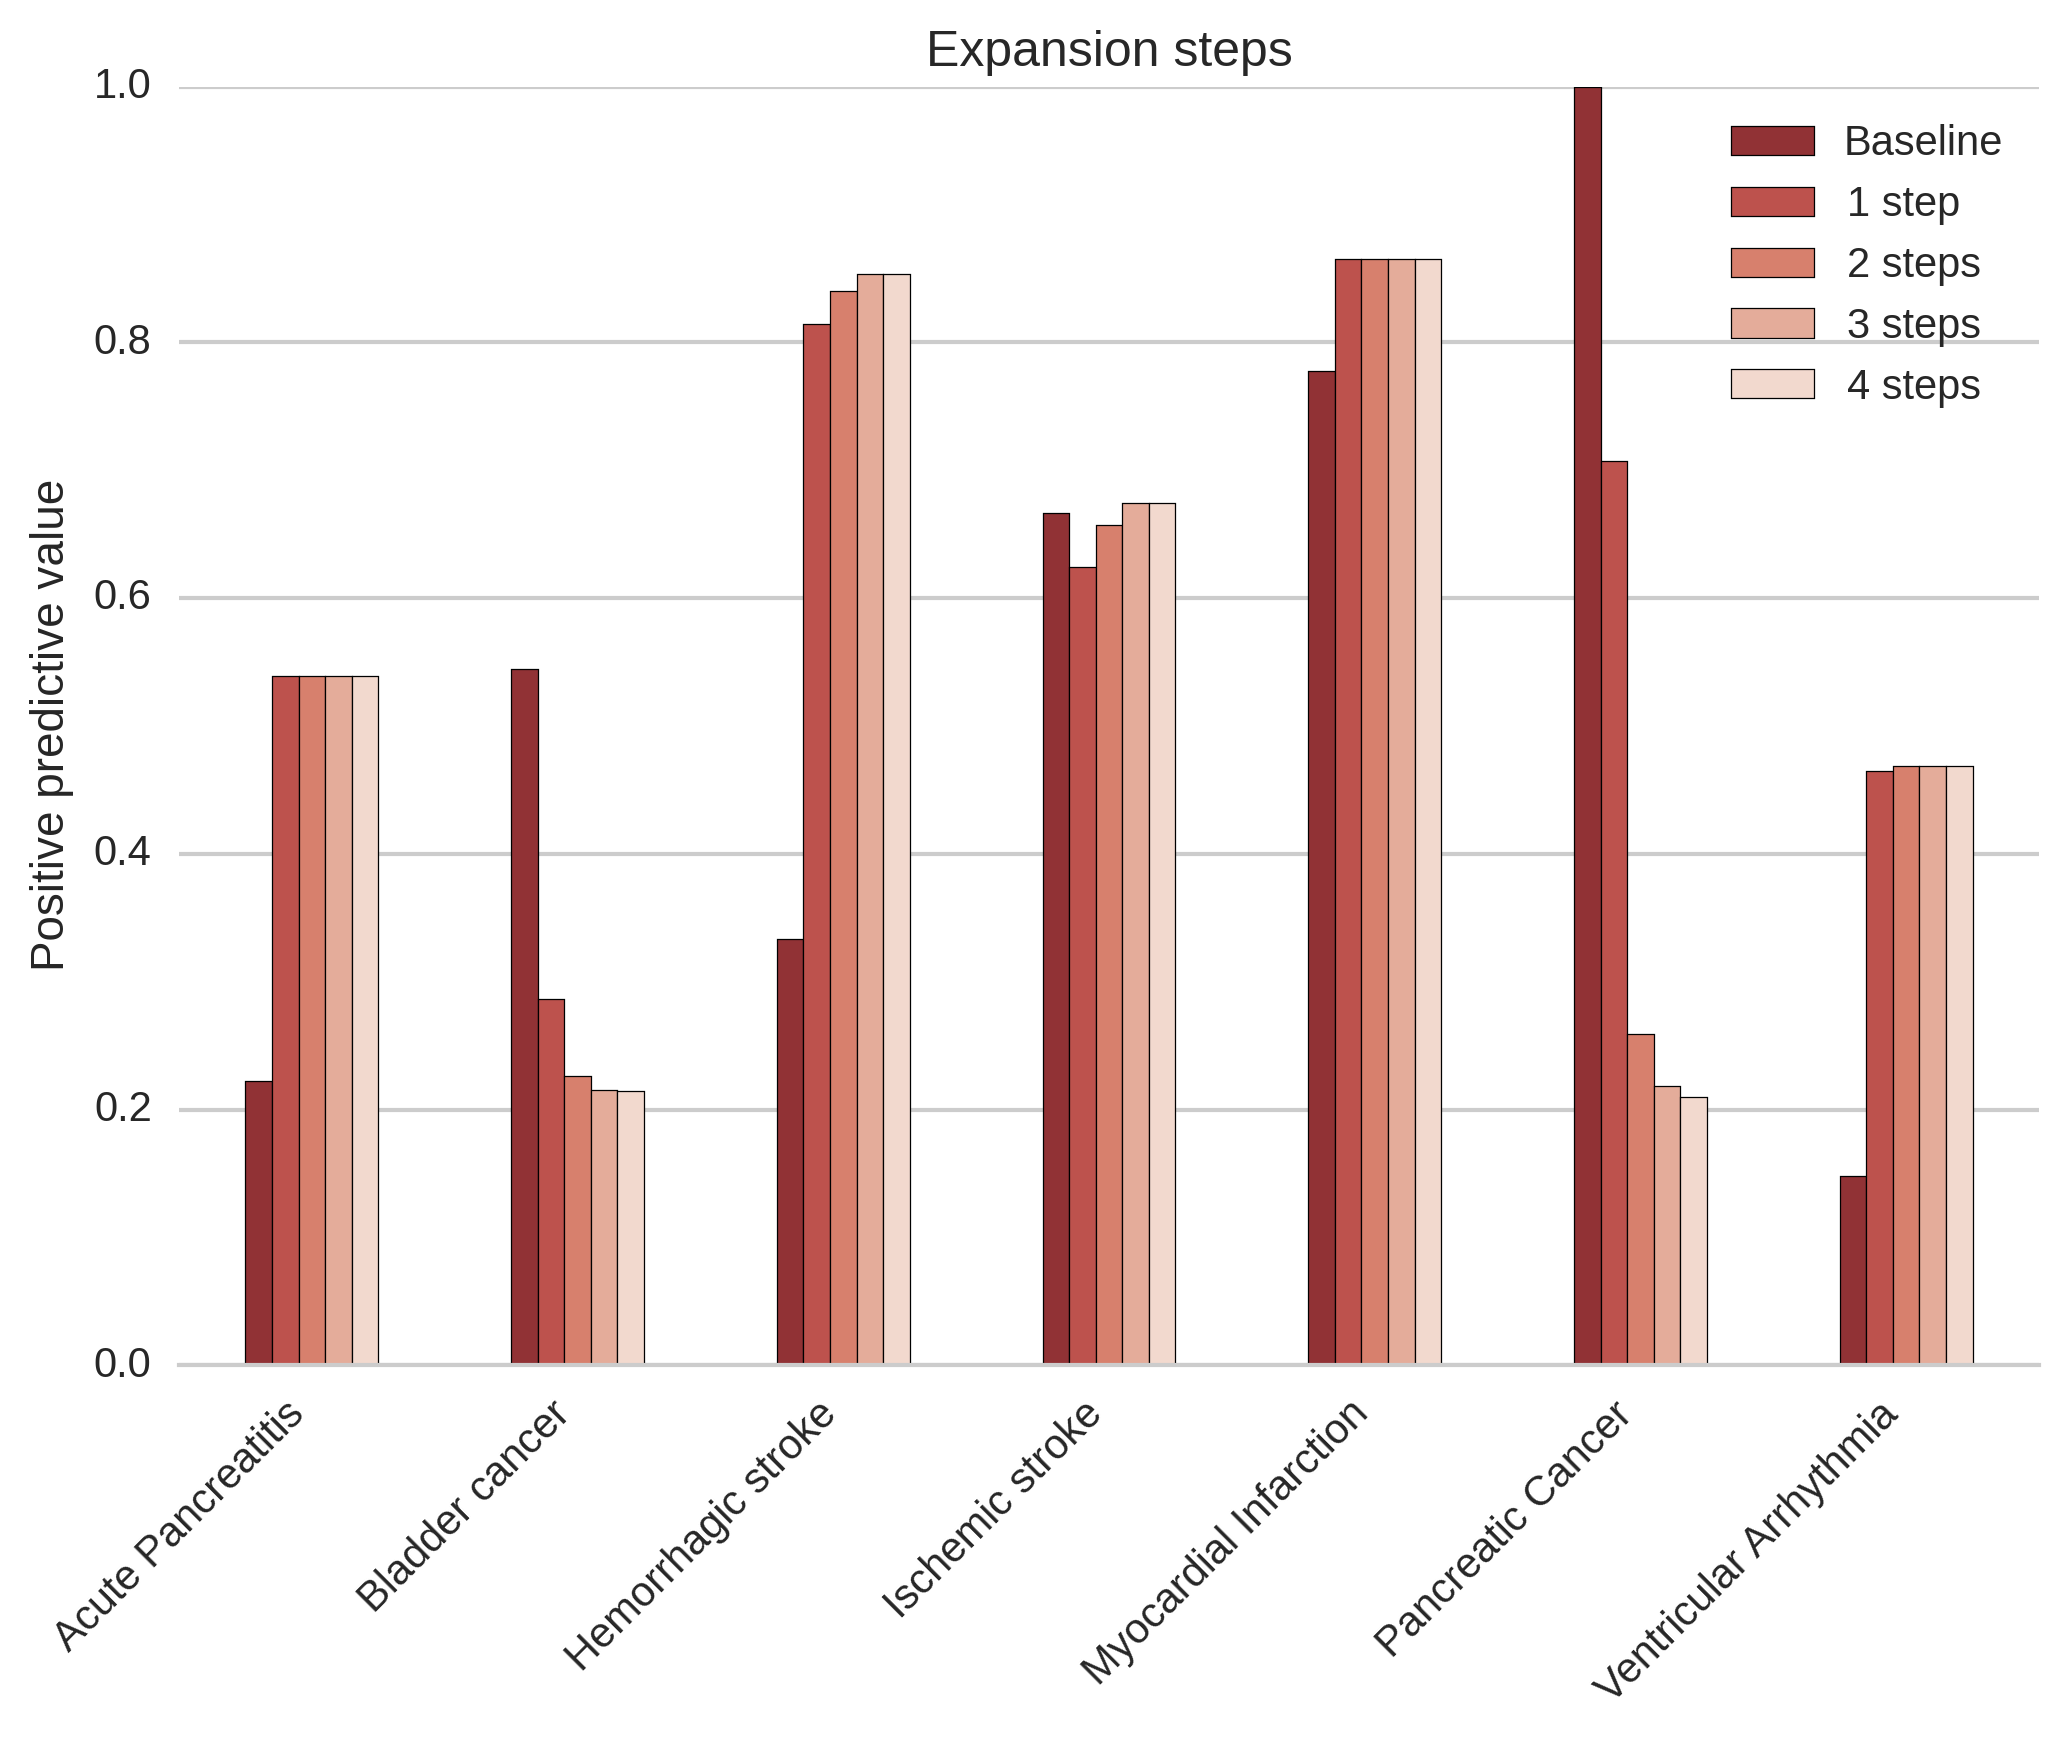

In [14]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('1-RN-CHD-RB-PAR.expand', '1 step'),
    ('2-RN-CHD-RB-PAR.expand', '2 steps'),
    ('3-RN-CHD-RB-PAR.expand', '3 steps'),
    ('4-RN-CHD-RB-PAR.expand', '4 steps'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index=compare_variations)
averages_compare.columns = averages_compare.columns.map(event_names.get)
averages_compare.index = compare_variations.values()

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Expansion steps")
    plt.ylabel(measure_label('precision'))

# Removing unused codes

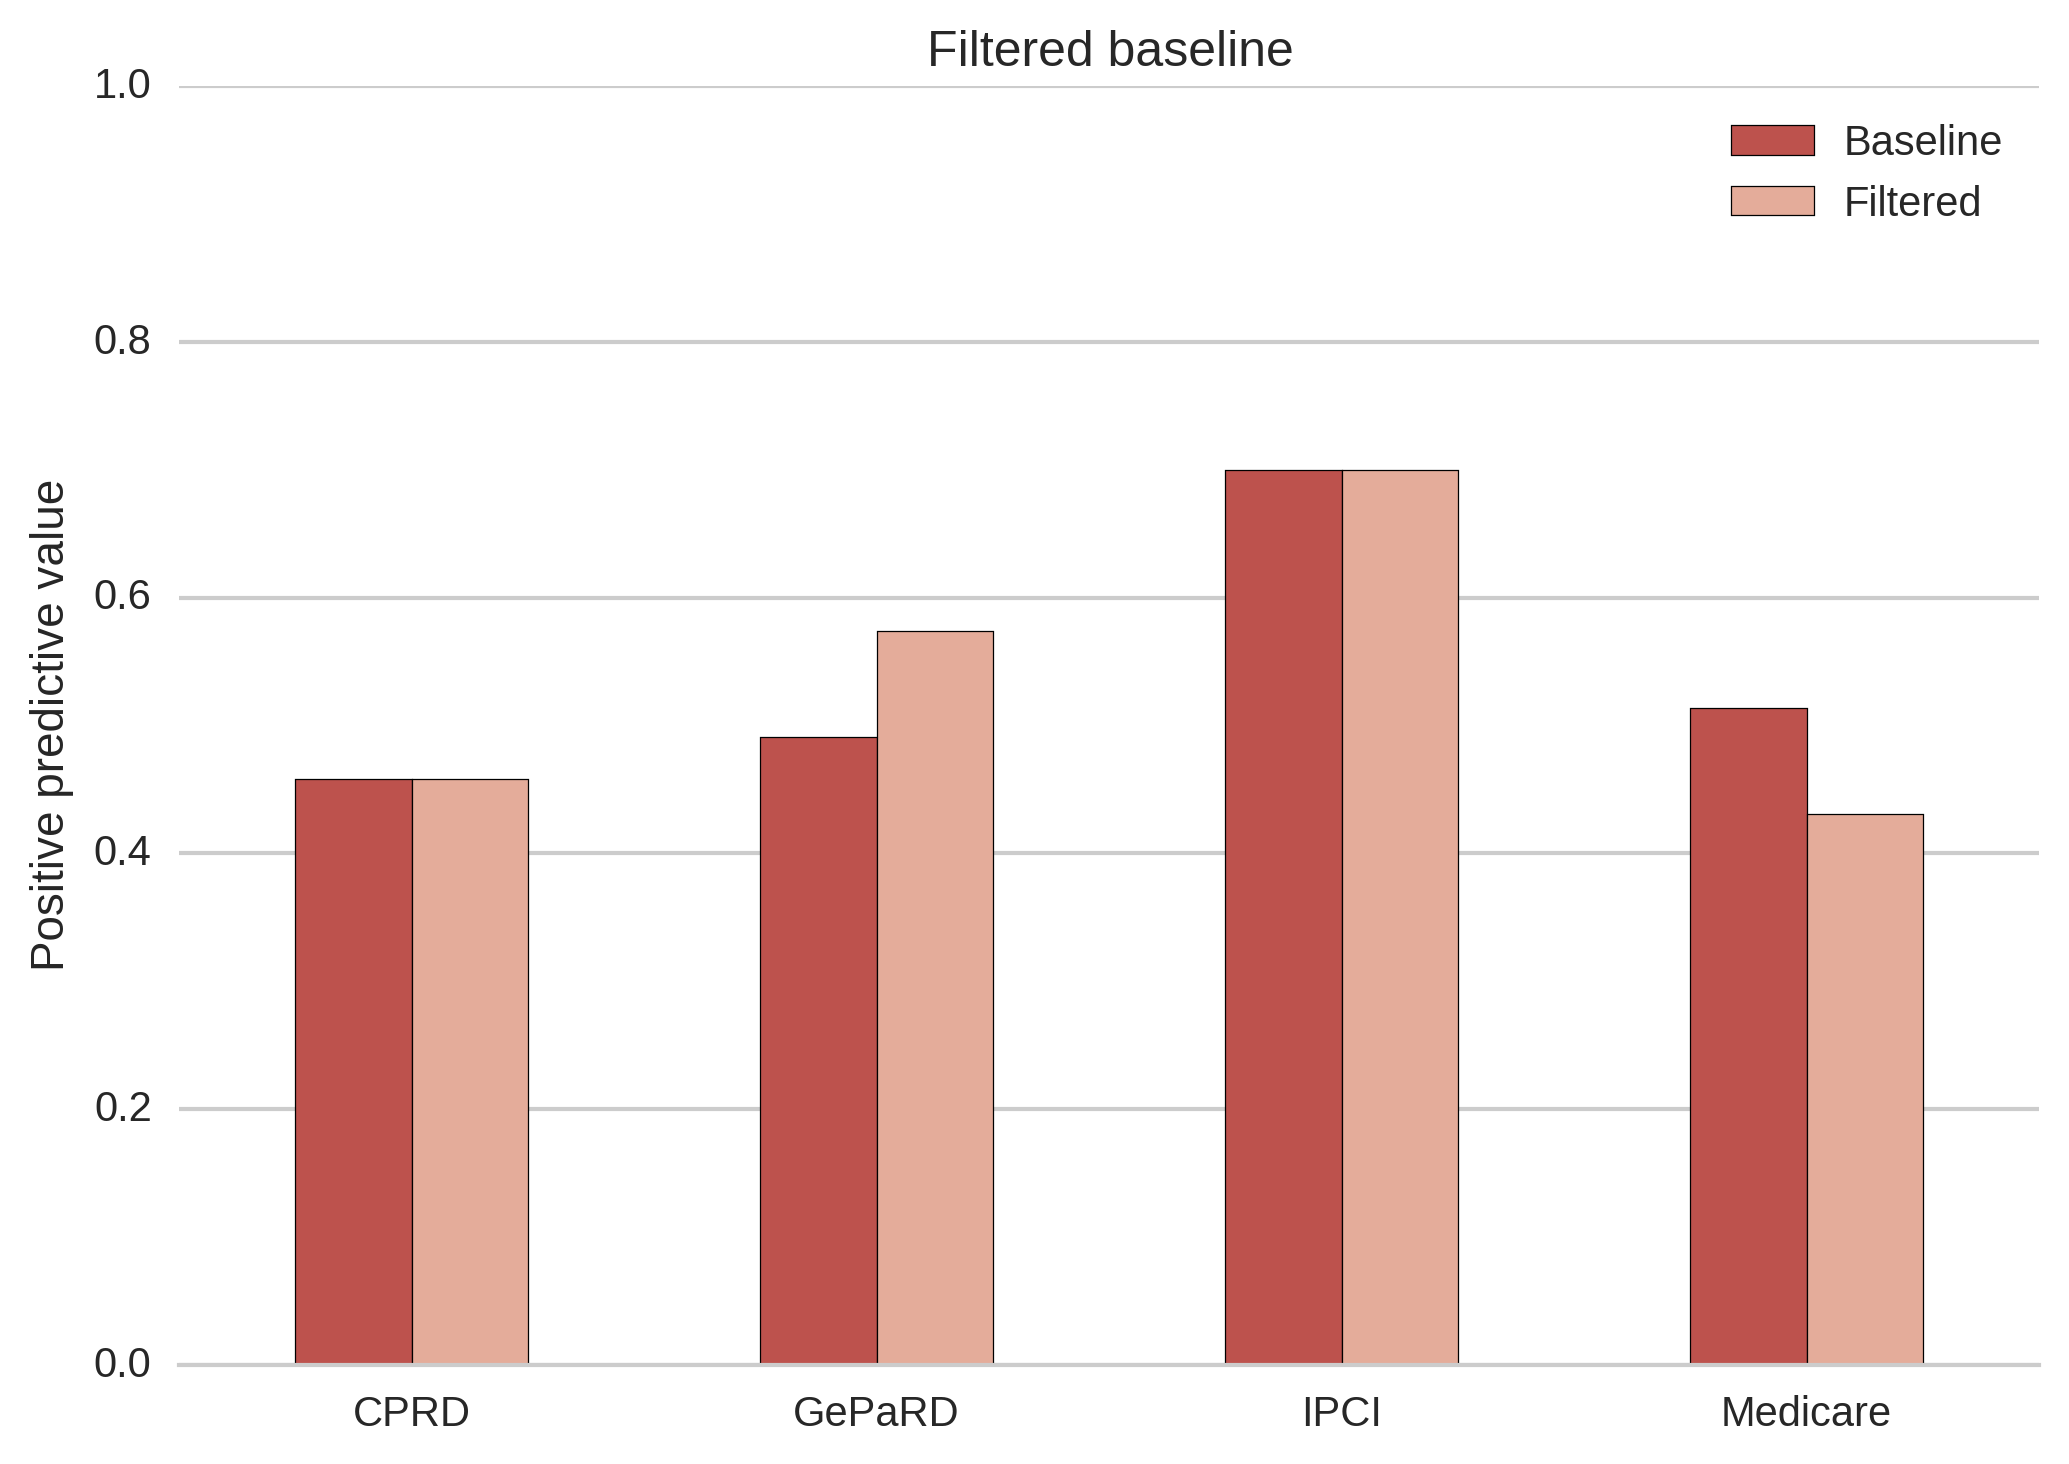

In [15]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations))):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))

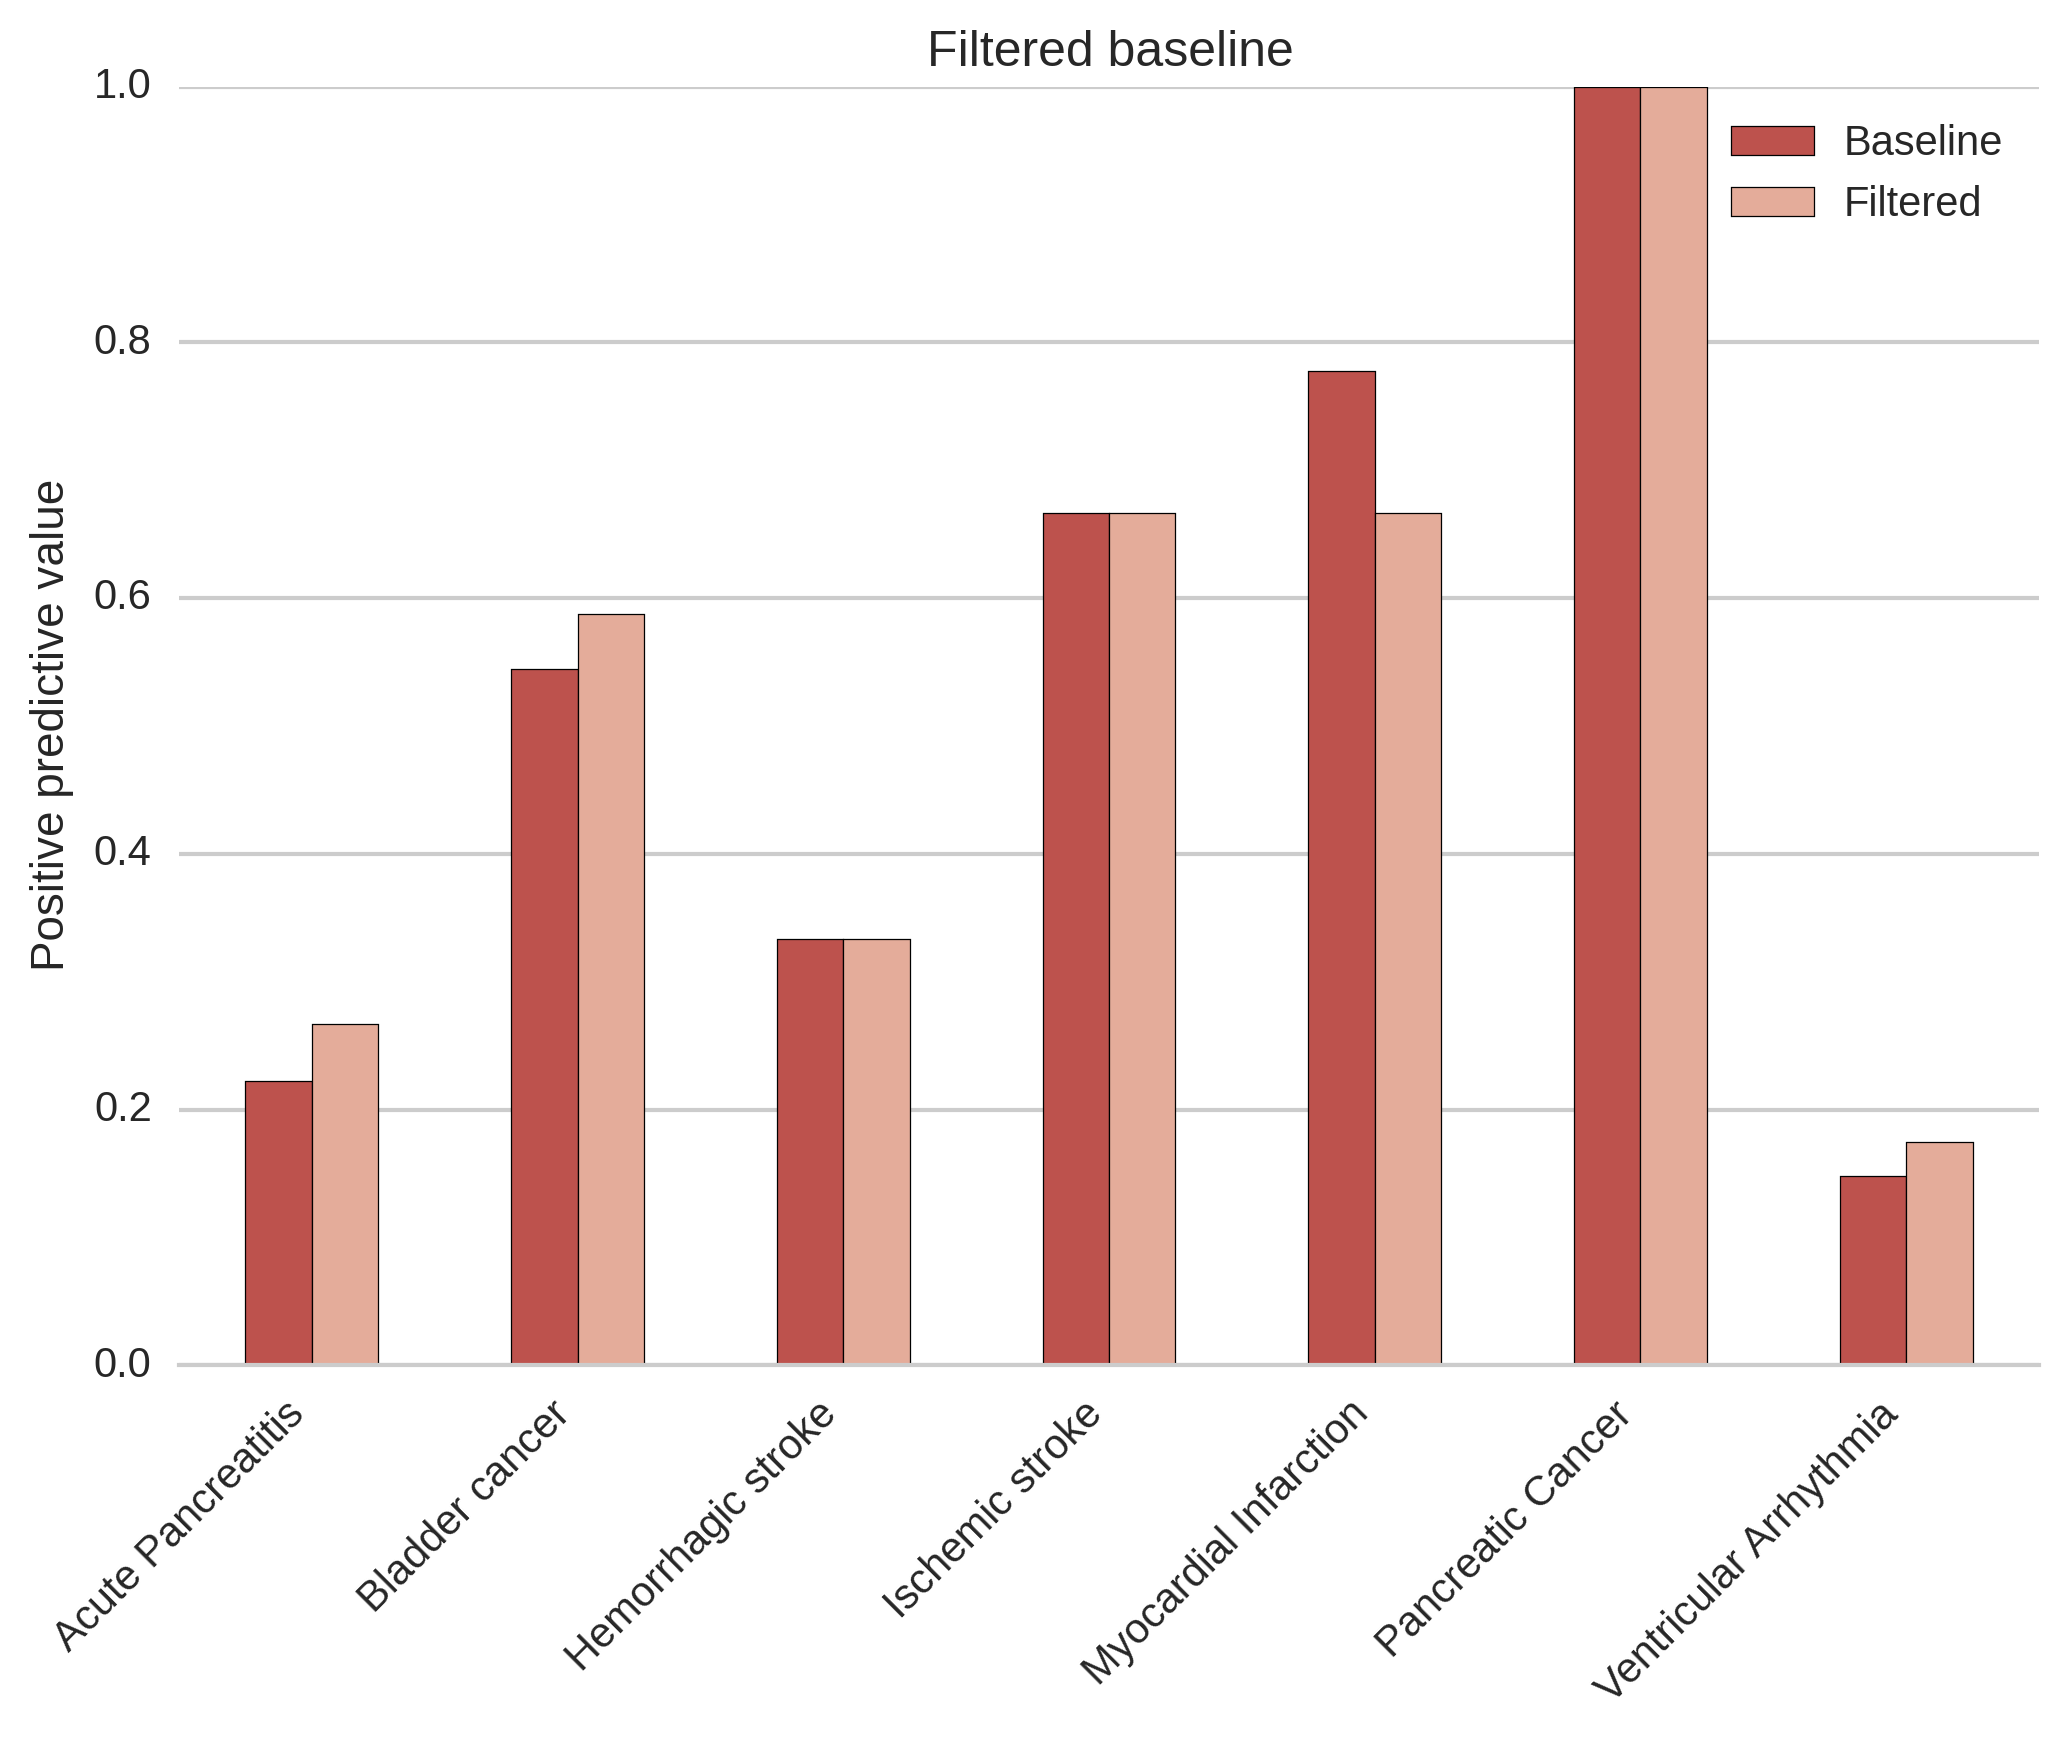

In [16]:
compare_variations = OrderedDict([
    ('baseline', 'Baseline'),
    ('baseline.filter-gen', 'Filtered'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_label)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Filtered baseline")
    plt.ylabel(measure_label('precision'))

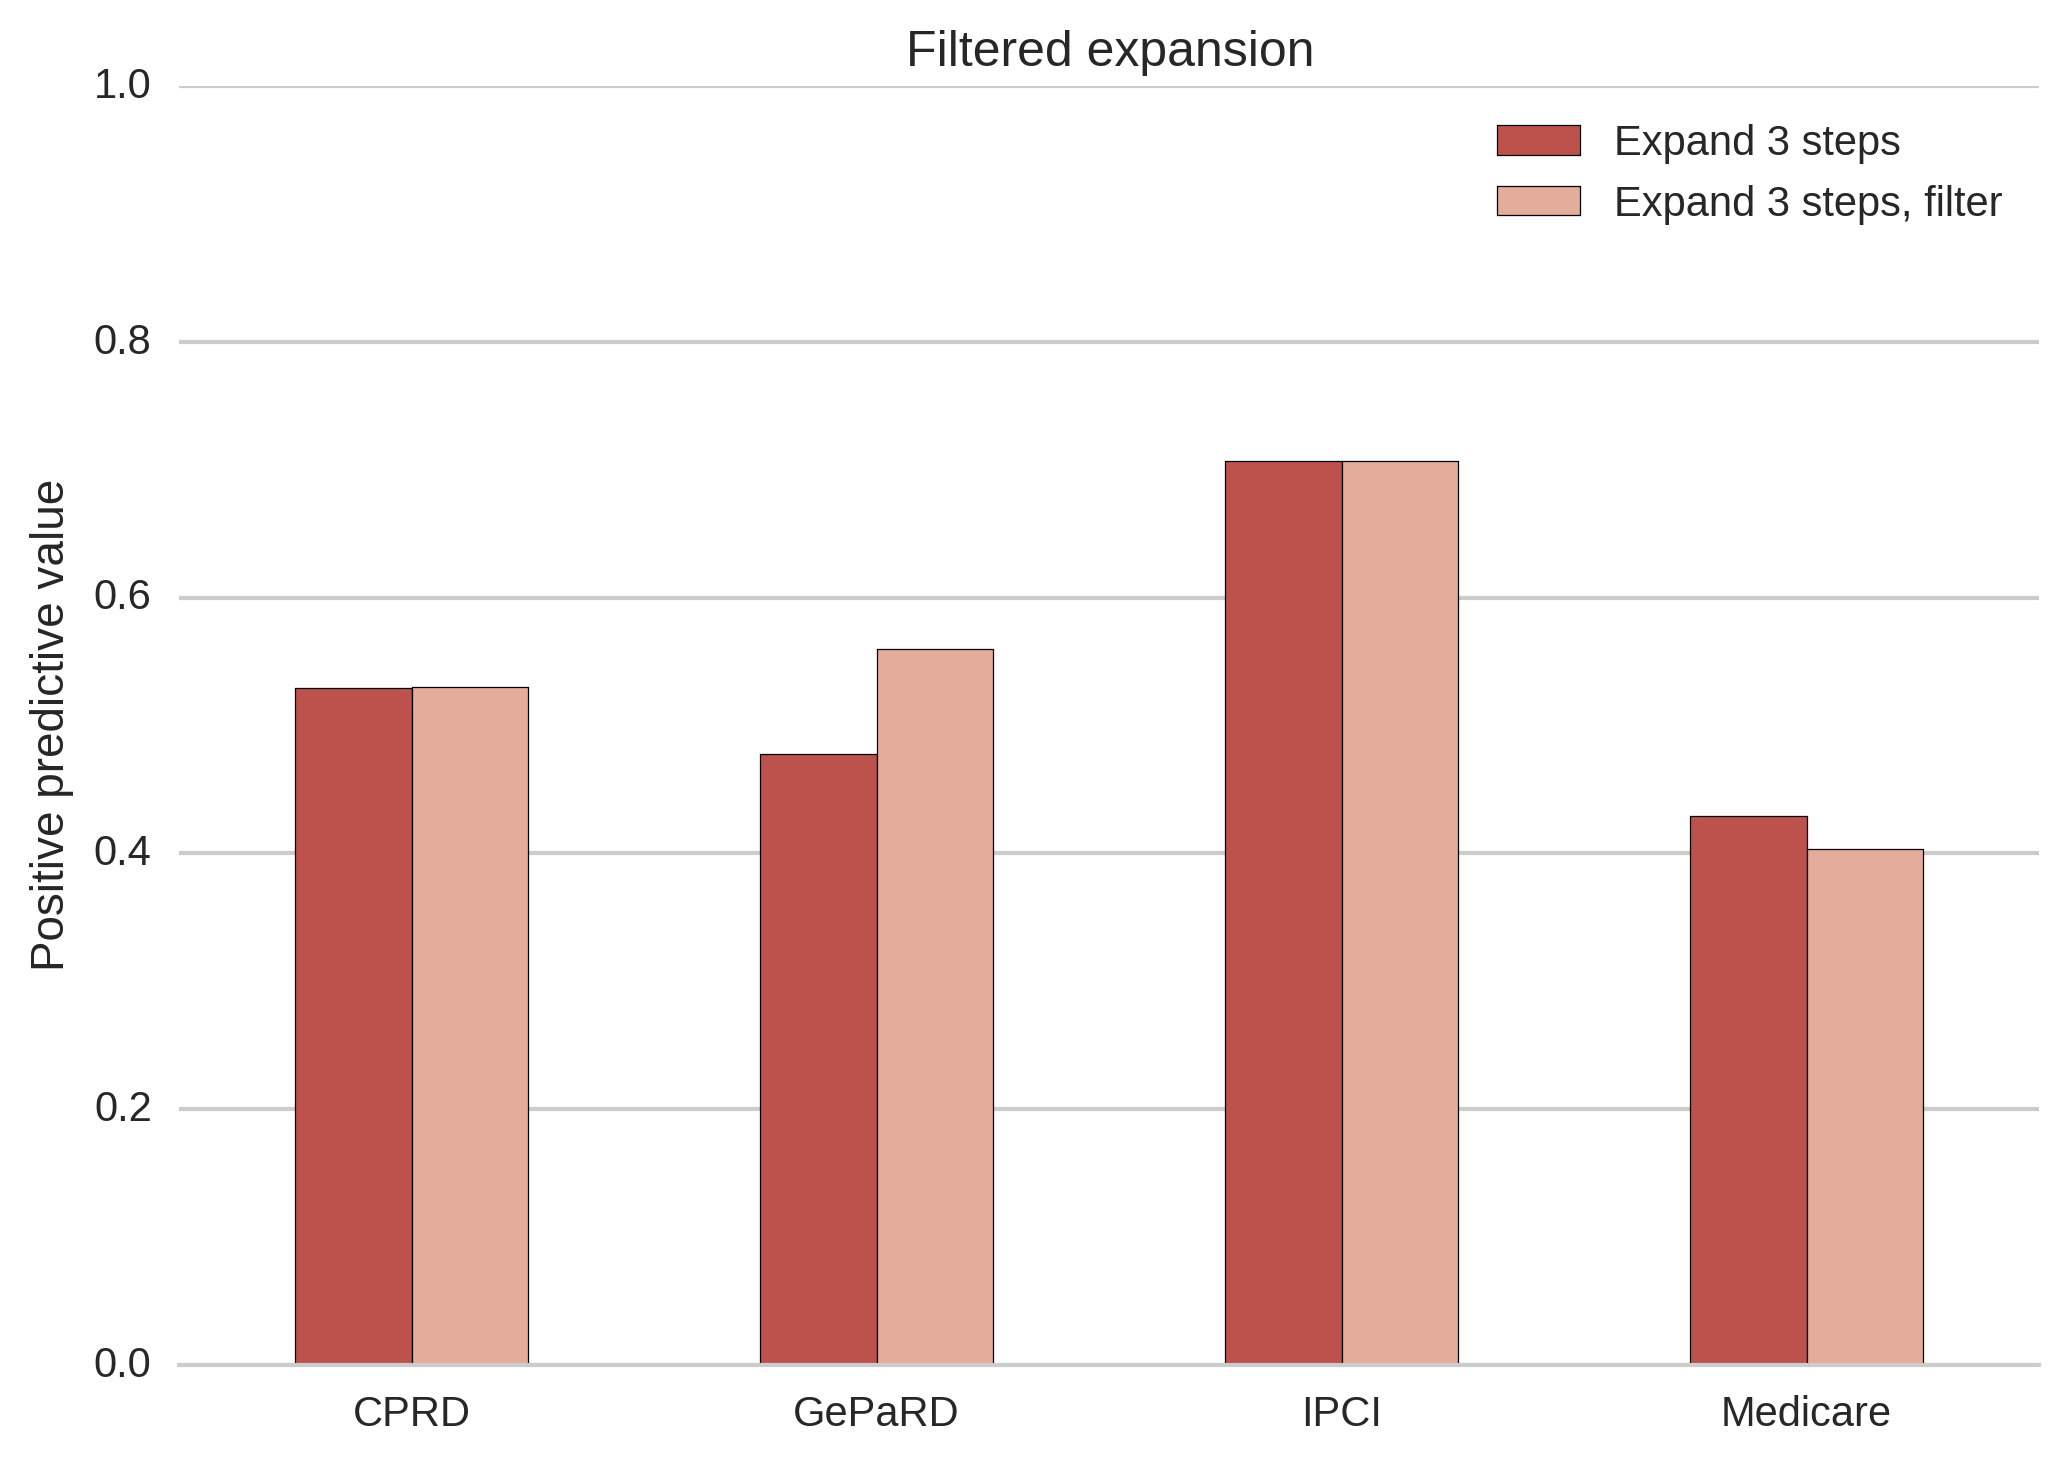

In [17]:
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('database').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(database_label)

with mystyle(graded_precision_palette(len(compare_variations))):
    averages_compare.T.plot(kind='bar', title="Filtered expansion")
    plt.ylabel(measure_label('precision'))

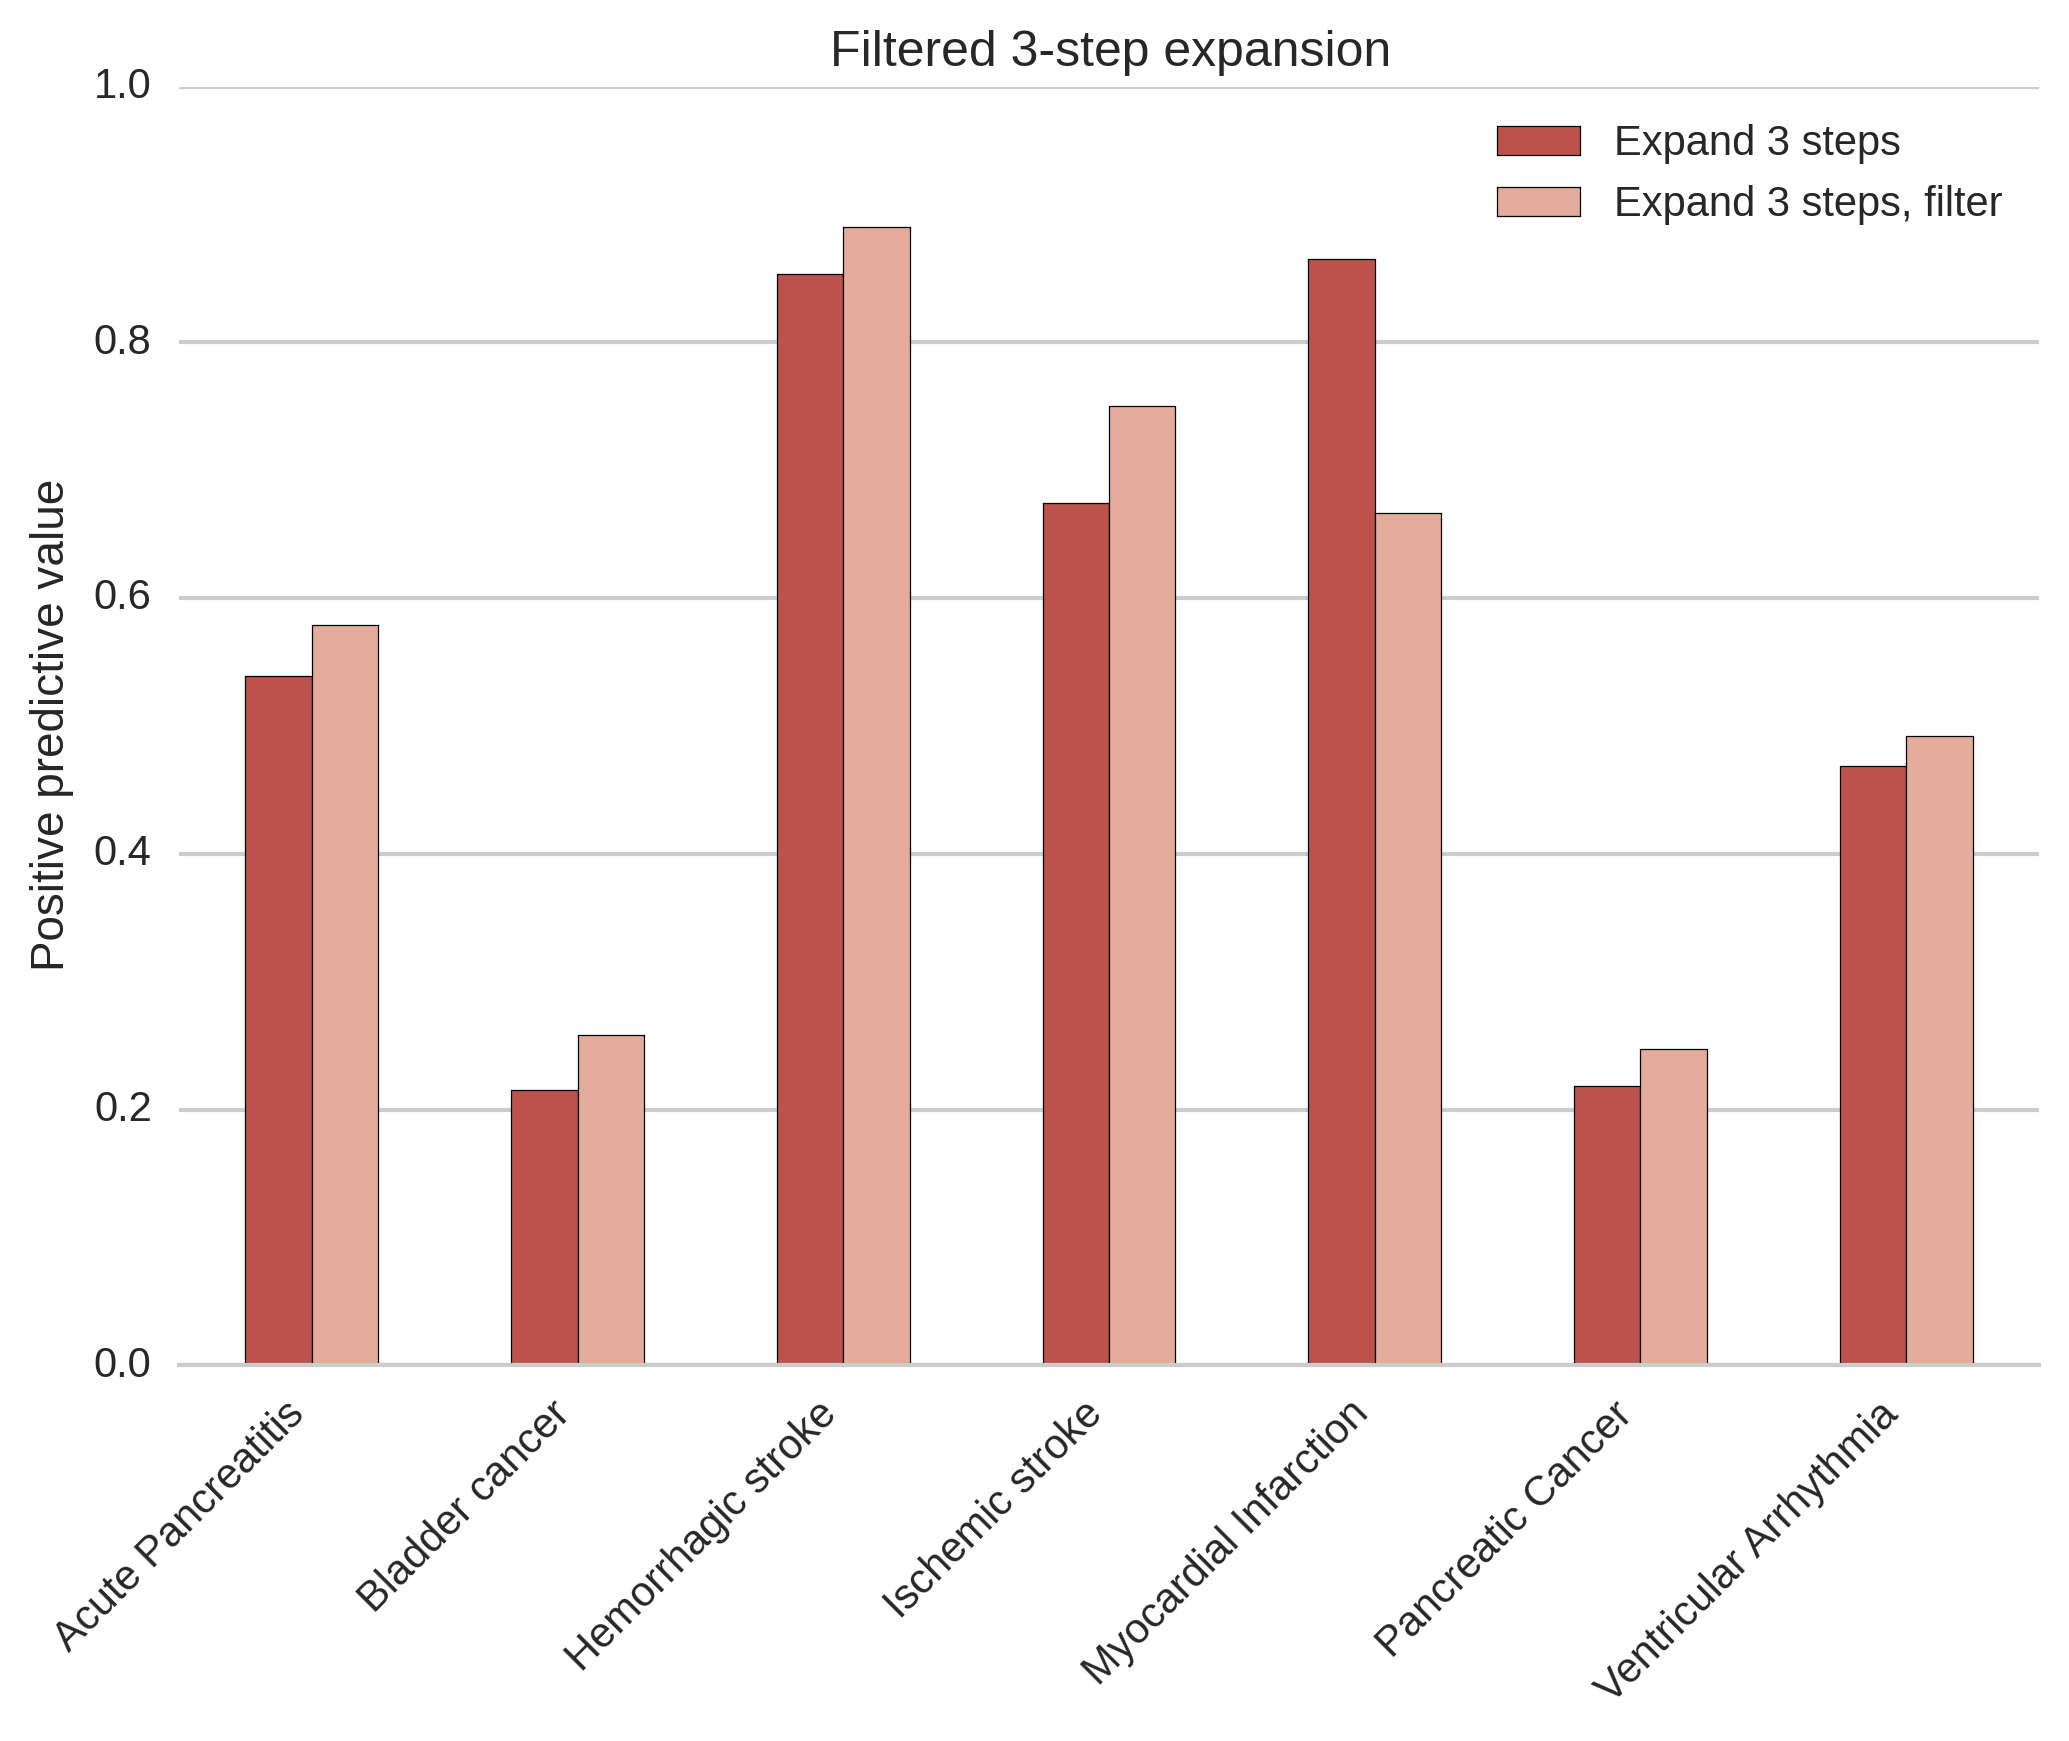

In [18]:
compare_variations = OrderedDict([
    ('3-RN-CHD-RB-PAR.expand', 'Expand 3 steps'),
    ('3-RN-CHD-RB-PAR.expand.filter-gen', 'Expand 3 steps, filter'),
])
averages_compare = pd.DataFrame([
    df[df.variation == variation].groupby('event').precision.mean()
    for variation in compare_variations
], index = compare_variations.values())
averages_compare.columns = averages_compare.columns.map(event_names.get)

with mystyle(graded_precision_palette(len(compare_variations)), xrot=45, ha='right'):
    averages_compare.T.plot(kind='bar', title="Filtered 3-step expansion")
    plt.ylabel(measure_label('precision'))

# Codes in reference mappings, not in databases

In [25]:
stats = DataFrame()
stats['In mapping'] = code_stats[code_stats.InMapping]\
    .groupby('Database').Code.count()
stats['In databases'] = code_stats[code_stats.InMapping & ~code_stats.InDatabase]\
    .groupby('Database').Code.count()
stats.fillna(0, inplace=True)
stats['%'] = (stats['In databases'] / stats['In mapping']).map("{:.2%}".format)
stats

,In mapping,In databases,%
Database,,,
CPRD,229,5,2.18%
GePaRD,74,1,1.35%
IPCI,16,0,0.00%
Medicare,53,15,28.30%
